In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate
from keras.models     import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop

import keras.backend as K

Using TensorFlow backend.


In [2]:
#  Program constants

train_ds_size  = 10000
train_points_c = np.linspace(0, 2, 3)
GAN_noise_size = 3

In [3]:
def randomly_sample_function (x, y, n_points) :
    y_cdf = np.zeros(shape=y.shape)
    for idx in range(1, len(y)) :
        slice_integral = 0.5 *np.fabs( y[idx-1] + y[idx] )
        y_cdf [idx] = y_cdf [idx-1] + slice_integral
    y_cdf = y_cdf / y_cdf[-1]
    u = np.random.uniform(0, 1, n_points)
    return np.interp(u, y_cdf, x)

In [4]:
def bin_data (data, bins=None, weights=None) :
    if type(bins) == type(None) :
        data_min, data_max = np.min(data), np.max(data)
        data_range = data_max - data_min
        bins = np.linspace(data_min-0.05*data_range, data_max+0.05*data_range, 11)
    if type(bins) != np.ndarray :
        bins = np.array(bins)
    if len(bins.shape) != 1 : raise RuntimeError("Provided bins must be one-dimensional array")
    if bins.shape[0] < 1    : raise RuntimeError("Provided bins must be one-dimensional array")
    if type(data) != np.ndarray :
        data = np.array(data)
    if len(data.shape) != 1 : raise RuntimeError("Provided data must be one-dimensional array")
    if type(weights) == type(None) :
        weights = np.full(shape=data.shape, fill_value=1.)
    bin_contents = np.zeros(shape=(bins.shape[0]-1,))
    for idx in range(len(bin_contents)) :
        bin_edge_low  = bins[idx  ]
        bin_edge_high = bins[idx+1]
        content = 0
        for datum, weight in zip(data, weights) :
            if datum < bin_edge_low  : continue
            if datum > bin_edge_high : continue
            content = content + weight
        bin_contents[idx] = content
    return bin_contents

In [5]:
class Param :
    def __init__ (self, name=None, value=None, lower_lim=None, upper_lim=None) :
        self.clear()
        if type(name     ) != type(None) : self.name      = name
        if type(value    ) != type(None) : self.value     = value
        if type(lower_lim) != type(None) : self.lower_lim = lower_lim
        if type(upper_lim) != type(None) : self.upper_lim = upper_lim
    def clear (self) :
        self.name       = ""
        self.value      = 0.
        self.upper_lim  = None
        self.lower_lim  = None

In [6]:
class Simulator :
    def __init__ (self) :
        self.clear()
    def add_param (self, name, value=0, lower_lim=None, upper_lim=None) :
        self.params.append(Param(name, value, lower_lim, upper_lim))
    def clear (self) :
        self.params    = []
        self.generator = None
    def get_param (self, name) :
        for param in self.params :
            if param.name != name : continue
            return param
        raise KeyError(f"Simulator object contains no param called '{name}'")
    def set_param_value (self, name, value=None) :
        self.get_param(name).value = value
    def generate (self, num=1, *argv, **kwargs) :
        if type(self.generator) is type(None) :
            raise RuntimeError("Simulator.generate(...) requires Simulator.generator to have been configured")
        return self.generator(self.params, num, *argv, **kwargs)

In [7]:
class ParameterisedSimulator (Simulator) :
    def __init__ (self, name="", xmin=None, xmax=None, xres=None) :
        self.clear()
        if len(name) > 0 :
            self.name = name
        self.set_function()
    def clear (self) :
        super(ParameterisedSimulator, self).clear()
        self.name     = ""
        self.function = None
    def set_function (self) :
        def generator (params, n_points, *argv, **kwargs) :
            params    = {p.name:p.value for p in params}
            c         = params["cX"]
            SM_xsec   = 2.
            int_xsec  = 0.5*c
            c_xsec    = 0.5*c*c
            tot_xsec  = SM_xsec + int_xsec + c_xsec
            pT        = np.linspace(50, 500, 4501)
            prob_pT   = tot_xsec / (pT*pT) 
            dphi      = np.linspace(-1.*np.pi, 1.*np.pi, 6900)
            prob_dphi = SM_xsec + c_xsec*np.sin(dphi)
            weights   = np.full(shape=(n_points,), fill_value=tot_xsec)
            #return weights.transpose()
            return np.array([
                             weights
                             #, randomly_sample_function (pT  , prob_pT  , n_points)
                             , randomly_sample_function (dphi, prob_dphi, n_points)
                            ]).transpose()
        self.generator = generator
        


In [8]:
#  Create a training dataset of size train_ds_size
#  For each c, the dataset is a Nx3 array with columns of [tot_xsec, pT, dphi]

A = ParameterisedSimulator()
A.add_param("cX", 0.)

datasets = {}
for c in train_points_c :
    A.set_param_value("cX", c)
    datasets[c] = A.generate(train_ds_size)
    ds_shape = datasets[c].shape
    if   len(ds_shape) == 1 : num_observables = 1
    elif len(ds_shape) == 2 : num_observables = ds_shape[1]
    else : raise RuntimeError(f"Could not interpret num_observables from shape {ds_shape}")

In [9]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


def make_new_critic_generator_wgan (num_observables, verbose=True) :
    if verbose : print(f"Creating WGAN with {num_observables} observables")
        
    data_input      = Input((num_observables,))
    condition_input = Input((1,))
    noise_input     = Input((GAN_noise_size,))


    critic_data = Dense(10, activation="relu")(data_input)
    #critic_data = Dropout(0.2)(critic_data)

    critic_condition = Dense(10, activation="relu")(condition_input)
    #critic_condition = Dropout(0.2)(critic_condition)

    critic = Concatenate()([critic_data, critic_condition])
    critic = Dense(20 , activation="relu")(critic)
    #critic = BatchNormalization()(critic)
    critic = Dense(20 , activation="relu")(critic)
    #critic = Dropout(0.2)(critic)
    critic = Dense(1, activation="linear")(critic)

    critic = Model(name="Critic", inputs=[data_input, condition_input], outputs=[critic])
    critic.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=5e-5, rho=0))
    if verbose : critic.summary()


    generator_noise = Dense(20, activation="relu")(noise_input)
    #generator_noise = Dropout(0.2)(generator_noise)
    generator_noise = BatchNormalization()(generator_noise)

    generator_condition = Dense(10, activation="relu")(condition_input)

    generator = Concatenate()([generator_noise, generator_condition])
    generator = Dense(20, activation="relu")(generator)
    #generator = BatchNormalization()(generator)
    generator = Dense(20, activation="relu")(generator)
    #generator = Dropout(0.2)(generator)
    generator = Dense(num_observables, activation="linear")(generator)

    generator = Model(name="Generator", inputs=[noise_input, condition_input], outputs=[generator])
    if verbose : generator.summary()


    GAN = critic([generator([noise_input, condition_input]), condition_input])
    GAN = Model([noise_input, condition_input], GAN, name="GAN")
    critic.trainable = False
    GAN.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=5e-5, rho=0))
    if verbose : GAN.summary()
        
    return critic, generator, GAN

In [10]:
def get_batch_size (original_batch_size, max_batch_size, epoch) :
    #return original_batch_size
    if max_batch_size >= original_batch_size :
        return min(original_batch_size + int(epoch/100.), max_batch_size)
    return original_batch_size + int(epoch/200.)
    
def get_noise (batch_size, train_points_c, GAN_noise_size) :
    hyperparams = np.concatenate([np.full(fill_value=c, shape=(batch_size, 1)) for c in train_points_c])
    return np.random.normal(size=(batch_size*len(train_points_c), GAN_noise_size)), hyperparams

def get_train_data (batch_size, train_points_c, datasets) :
    data_batch  = np.concatenate([dataset[np.random.randint(0, len(dataset), batch_size)] for c, dataset in datasets.items()])
    if len(data_batch.shape) == 1 :
        data_batch = data_batch.reshape((data_batch.shape[0],1))
    hyperparams = np.concatenate([np.full(fill_value=c, shape=(batch_size, 1)) for c in train_points_c])
    return data_batch, hyperparams

def get_train_fakes (batch_size, train_points_c, GAN_noise_size, generator) :
    noise, hyperparams = list(get_noise(batch_size, train_points_c, GAN_noise_size))
    fakes_batch = generator.predict([noise, hyperparams])
    return fakes_batch, hyperparams

In [11]:
def plot_progress (train_points_c, data_batch, data_conditions, fakes_batch, fakes_conditions) :
    num_observables = data_batch.shape[1]
    fig = plt.figure(figsize=(12, 3*num_observables))
    for obs_idx in range(num_observables) :
        data_proj  = data_batch [:,obs_idx]
        fakes_proj = fakes_batch[:,obs_idx]
        ax = fig.add_subplot(num_observables, 2, (2*obs_idx) + 1)
        xmin, xmax = None, None
        for idx, c in enumerate(train_points_c) :
            data = [x for x,y in zip(data_proj, data_conditions) if y==c]
            print(f"Data (c={c}) mean is {np.mean(data)}")
            _, bins, _ = plt.hist(data, alpha=0.3, label=f"c = {c}")
            if type(xmin) is type(None) : xmin = np.min(bins)
            else                        : xmin = np.min([xmin, np.min(bins)])
            if type(xmax) is type(None) : xmax = np.max(bins)
            else                        : xmax = np.max([xmax, np.max(bins)])
        xrange = xmax - xmin
        ax.set_xlim(xmin-0.05*xrange, xmax+0.4*xrange)
        plt.legend(loc="upper right", frameon=False, fontsize=10)
        ax = fig.add_subplot(num_observables, 2, (2*obs_idx) + 2)
        xmin, xmax = None, None
        for idx, c in enumerate(train_points_c) :
            fakes = [x for x,y in zip(fakes_proj, fakes_conditions) if y==c]
            print(f"Fakes (c={c}) mean is {np.mean(fakes)}")
            _, bins, _ = plt.hist(fakes, alpha=0.3, label=f"c = {c}")
            if type(xmin) is type(None) : xmin = np.min(bins)
            else                        : xmin = np.min([xmin, np.min(bins)])
            if type(xmax) is type(None) : xmax = np.max(bins)
            else                        : xmax = np.max([xmax, np.max(bins)])
        xrange = xmax - xmin
        ax.set_xlim(xmin-0.05*xrange, xmax+0.4*xrange)
        plt.legend(loc="upper right", frameon=False, fontsize=10)
    plt.show()
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 0 GAN loss is 0.3734833896160126
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 0.027614619582891464
Fakes (c=1.0) mean is 0.1269589364528656
Fakes (c=2.0) mean is 0.24295355379581451
Data (c=0.0) mean is 0.01884122511695224
Data (c=1.0) mean is 0.08018762914740302
Data (c=2.0) mean is 0.9510008477051234
Fakes (c=0.0) mean is -0.05581881105899811
Fakes (c=1.0) mean is 0.19326093792915344
Fakes (c=2.0) mean is 0.37503519654273987


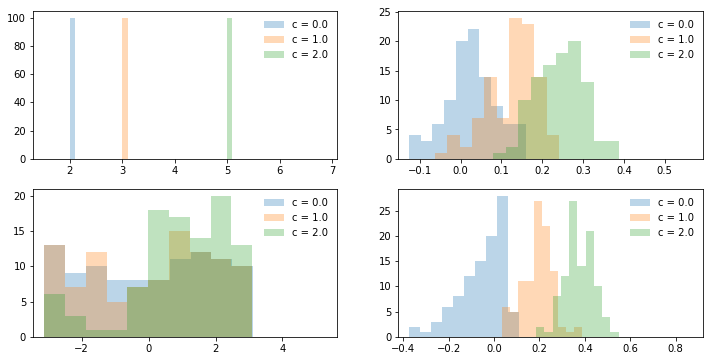

Epoch 1000 GAN loss is 13.366028785705566
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.1309669017791748
Fakes (c=1.0) mean is 1.1100001335144043
Fakes (c=2.0) mean is 1.1645678281784058
Data (c=0.0) mean is 0.35883538725952807
Data (c=1.0) mean is 0.37007349031638676
Data (c=2.0) mean is 0.9379950606617974
Fakes (c=0.0) mean is 0.03331848978996277
Fakes (c=1.0) mean is 0.23780259490013123
Fakes (c=2.0) mean is 0.3883799910545349


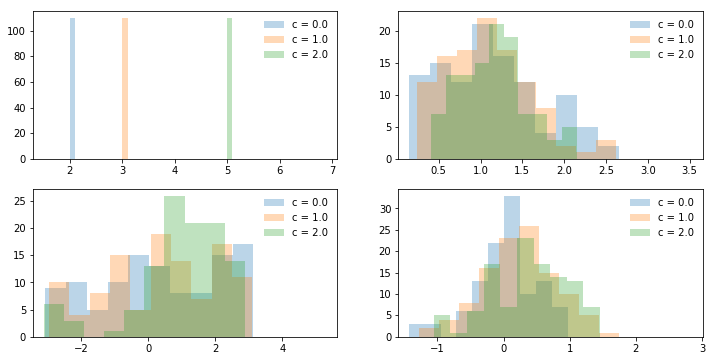

Epoch 2000 GAN loss is -51.59634780883789
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 4.516642093658447
Fakes (c=1.0) mean is 4.523833274841309
Fakes (c=2.0) mean is 4.927391529083252
Data (c=0.0) mean is -0.17810015208777746
Data (c=1.0) mean is 0.4354199957449081
Data (c=2.0) mean is 1.0153770576706886
Fakes (c=0.0) mean is 1.2343952655792236
Fakes (c=1.0) mean is 1.3230743408203125
Fakes (c=2.0) mean is 1.8155434131622314


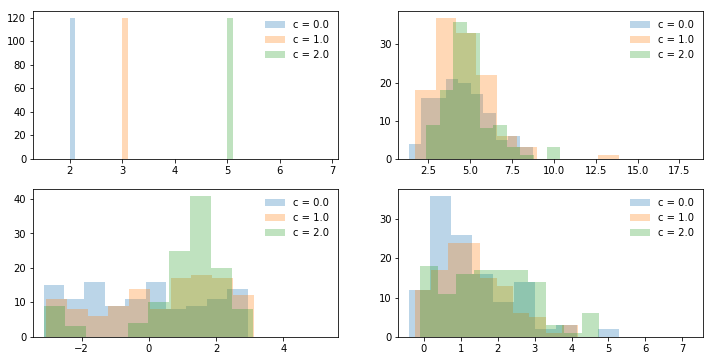

Epoch 3000 GAN loss is -9.328065872192383
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 10.337976455688477
Fakes (c=1.0) mean is 10.872949600219727
Fakes (c=2.0) mean is 12.526002883911133
Data (c=0.0) mean is 0.008341261277523498
Data (c=1.0) mean is 0.13292170298009118
Data (c=2.0) mean is 1.0179744497768475
Fakes (c=0.0) mean is 1.9380519390106201
Fakes (c=1.0) mean is 2.5555531978607178
Fakes (c=2.0) mean is 3.0240447521209717


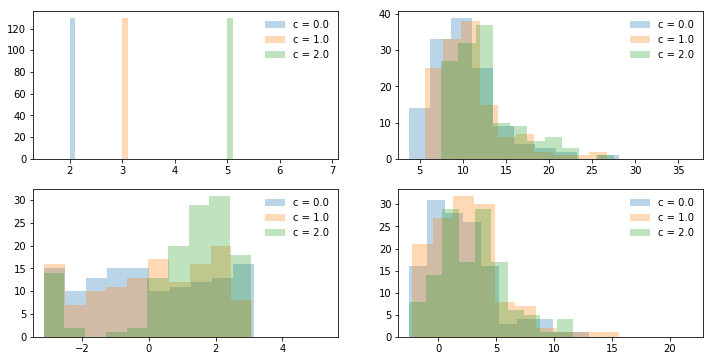

Epoch 4000 GAN loss is -28.98788070678711
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 5.513125896453857
Fakes (c=1.0) mean is 5.519076347351074
Fakes (c=2.0) mean is 6.183514595031738
Data (c=0.0) mean is -0.0734638916371501
Data (c=1.0) mean is 0.2866581411788982
Data (c=2.0) mean is 1.0271482851404874
Fakes (c=0.0) mean is -0.8124788403511047
Fakes (c=1.0) mean is 0.06667914241552353
Fakes (c=2.0) mean is 0.8217962980270386


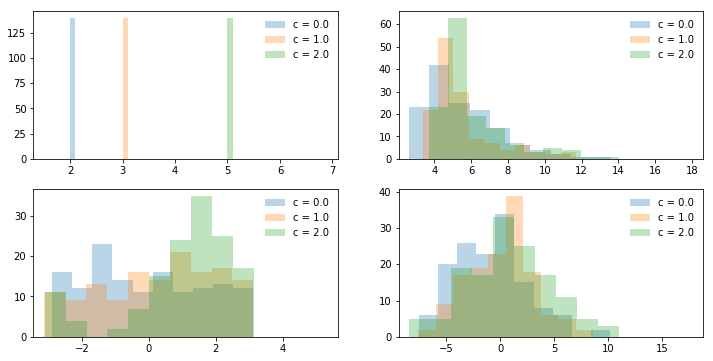

Epoch 5000 GAN loss is -99.55374908447266
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 3.2671446800231934
Fakes (c=1.0) mean is 4.119318008422852
Fakes (c=2.0) mean is 5.046133518218994
Data (c=0.0) mean is 0.02511814187052675
Data (c=1.0) mean is 0.14484727023672903
Data (c=2.0) mean is 0.8357948186013735
Fakes (c=0.0) mean is -0.26386719942092896
Fakes (c=1.0) mean is -0.4150927662849426
Fakes (c=2.0) mean is 0.993796169757843


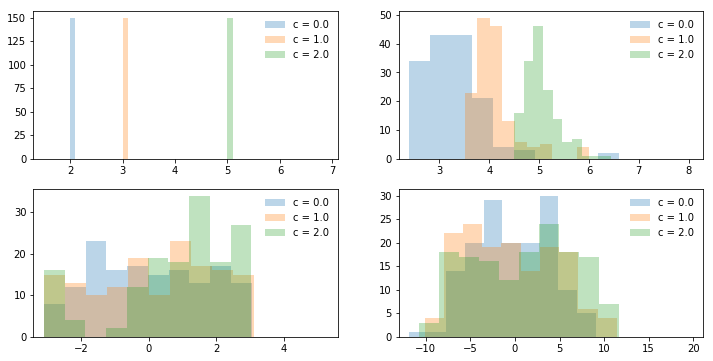

Epoch 6000 GAN loss is -259.62615966796875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.6262108087539673
Fakes (c=1.0) mean is 3.326192855834961
Fakes (c=2.0) mean is 5.255345821380615
Data (c=0.0) mean is -0.019322152362474344
Data (c=1.0) mean is 0.20921103321975143
Data (c=2.0) mean is 0.9199095077202625
Fakes (c=0.0) mean is 0.25436481833457947
Fakes (c=1.0) mean is 0.8551017642021179
Fakes (c=2.0) mean is 1.349168062210083


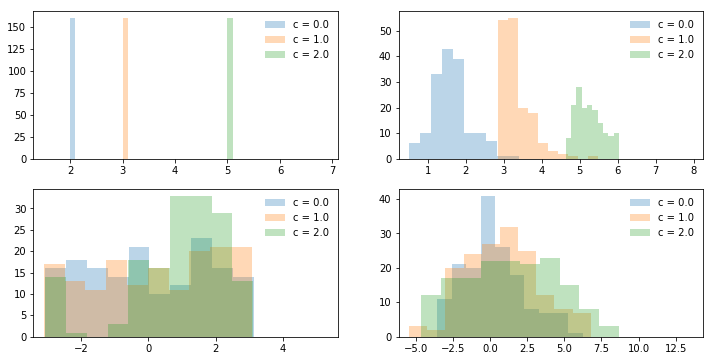

Epoch 7000 GAN loss is -405.7376708984375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.5576541423797607
Fakes (c=1.0) mean is 3.192880392074585
Fakes (c=2.0) mean is 5.022828102111816
Data (c=0.0) mean is -6.742419587064152e-05
Data (c=1.0) mean is 0.24534164279369725
Data (c=2.0) mean is 0.938640315733708
Fakes (c=0.0) mean is -0.20482803881168365
Fakes (c=1.0) mean is 0.20066577196121216
Fakes (c=2.0) mean is 0.7681118845939636


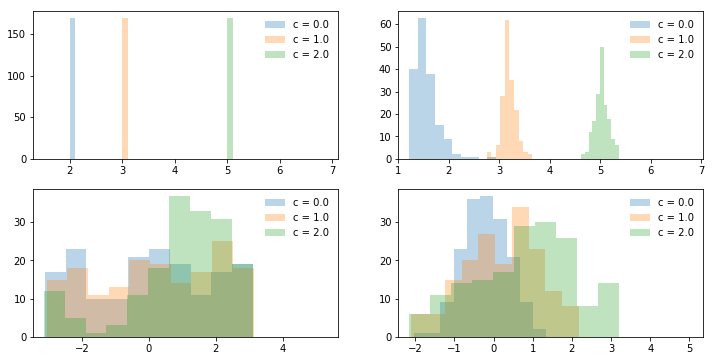

Epoch 8000 GAN loss is -390.7831726074219
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.8124823570251465
Fakes (c=1.0) mean is 3.2871792316436768
Fakes (c=2.0) mean is 5.009050369262695
Data (c=0.0) mean is -0.1847418431795965
Data (c=1.0) mean is 0.29516294196330994
Data (c=2.0) mean is 0.9577903729506014
Fakes (c=0.0) mean is -0.29777827858924866
Fakes (c=1.0) mean is 0.2382529377937317
Fakes (c=2.0) mean is 1.0343095064163208


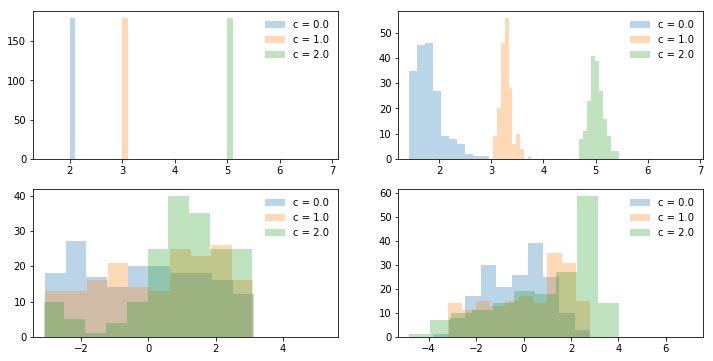

Epoch 9000 GAN loss is -496.4691467285156
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.7948664426803589
Fakes (c=1.0) mean is 3.308924674987793
Fakes (c=2.0) mean is 5.013083457946777
Data (c=0.0) mean is -0.10634930940161265
Data (c=1.0) mean is 0.26198574331542285
Data (c=2.0) mean is 0.9189002126470922
Fakes (c=0.0) mean is 0.14487959444522858
Fakes (c=1.0) mean is 0.29157453775405884
Fakes (c=2.0) mean is 0.7433321475982666


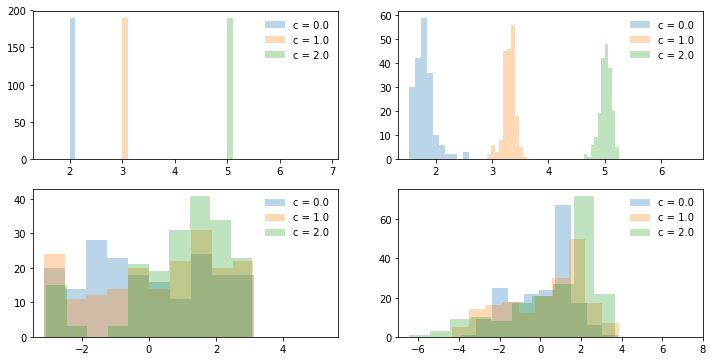

Epoch 10000 GAN loss is -829.3544921875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.8557543754577637
Fakes (c=1.0) mean is 3.265587091445923
Fakes (c=2.0) mean is 4.9354143142700195
Data (c=0.0) mean is -0.1741573926574835
Data (c=1.0) mean is 0.23773593575916516
Data (c=2.0) mean is 1.1361251458812316
Fakes (c=0.0) mean is 0.42445117235183716
Fakes (c=1.0) mean is 0.29525044560432434
Fakes (c=2.0) mean is 0.5404834747314453


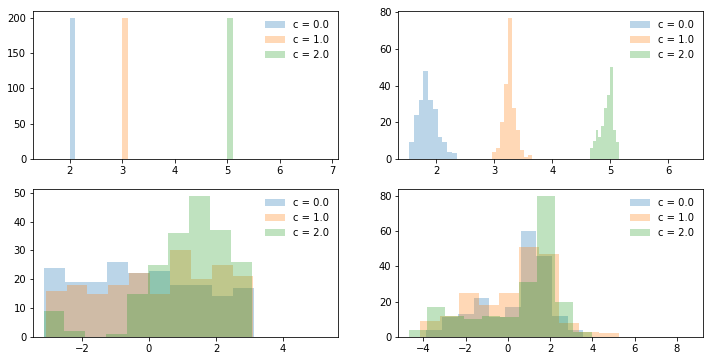

Epoch 11000 GAN loss is -1001.9608154296875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.8749576807022095
Fakes (c=1.0) mean is 3.200460910797119
Fakes (c=2.0) mean is 4.94230842590332
Data (c=0.0) mean is 0.04014421062990672
Data (c=1.0) mean is 0.3256950091538898
Data (c=2.0) mean is 1.1132059325176331
Fakes (c=0.0) mean is -0.13225486874580383
Fakes (c=1.0) mean is 0.23086751997470856
Fakes (c=2.0) mean is 0.8262714147567749


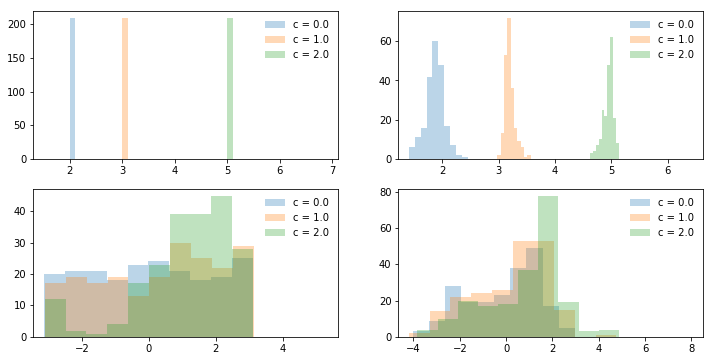

Epoch 12000 GAN loss is -1011.0001220703125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.9301271438598633
Fakes (c=1.0) mean is 3.094334363937378
Fakes (c=2.0) mean is 4.949823379516602
Data (c=0.0) mean is 0.025380576050473124
Data (c=1.0) mean is 0.1964663058771902
Data (c=2.0) mean is 0.8938591674376596
Fakes (c=0.0) mean is -0.5103658437728882
Fakes (c=1.0) mean is 0.1781565546989441
Fakes (c=2.0) mean is 1.2838786840438843


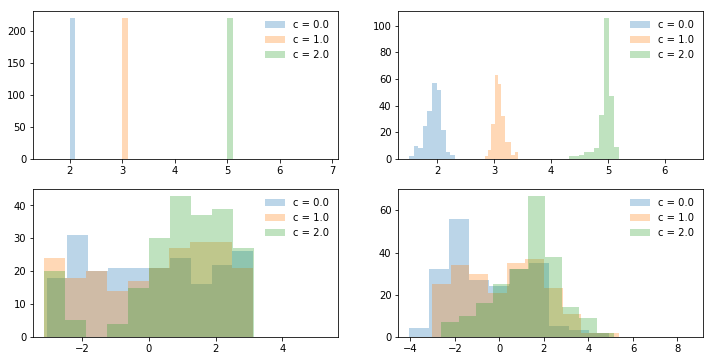

Epoch 13000 GAN loss is -1145.416015625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0023715496063232
Fakes (c=1.0) mean is 3.013263702392578
Fakes (c=2.0) mean is 4.994530200958252
Data (c=0.0) mean is 0.20527497446458468
Data (c=1.0) mean is 0.21117332917636095
Data (c=2.0) mean is 0.8540515889202668
Fakes (c=0.0) mean is -0.2763117849826813
Fakes (c=1.0) mean is 0.3710269331932068
Fakes (c=2.0) mean is 1.4829316139221191


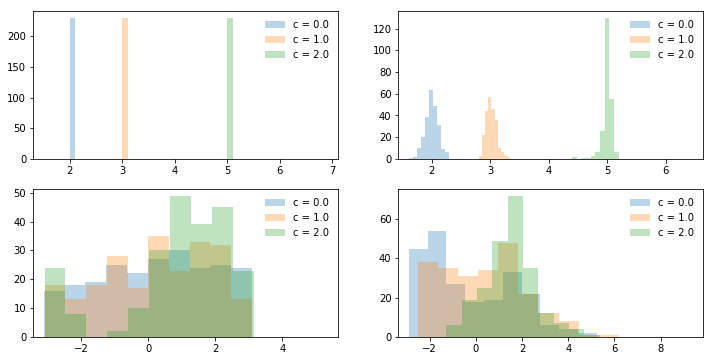

Epoch 14000 GAN loss is -1256.85205078125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0109994411468506
Fakes (c=1.0) mean is 2.9803264141082764
Fakes (c=2.0) mean is 5.003255844116211
Data (c=0.0) mean is -0.041374861469486816
Data (c=1.0) mean is 0.28001770623761973
Data (c=2.0) mean is 0.9466156227803537
Fakes (c=0.0) mean is -0.02380446158349514
Fakes (c=1.0) mean is 0.2576536238193512
Fakes (c=2.0) mean is 1.3341376781463623


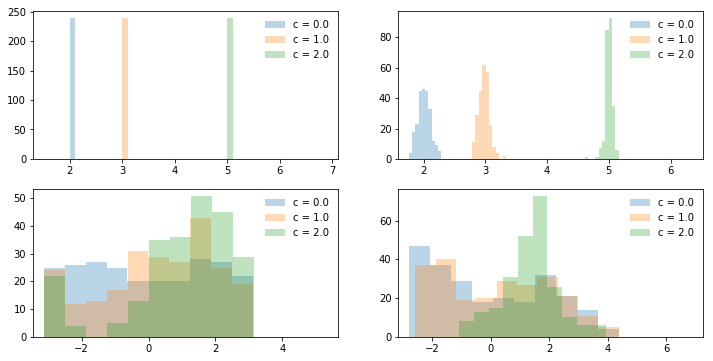

Epoch 15000 GAN loss is -1399.935791015625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0245440006256104
Fakes (c=1.0) mean is 2.9912142753601074
Fakes (c=2.0) mean is 5.003046989440918
Data (c=0.0) mean is 0.1659415016853138
Data (c=1.0) mean is 0.13946710230123743
Data (c=2.0) mean is 0.758389637054431
Fakes (c=0.0) mean is 0.07946080714464188
Fakes (c=1.0) mean is 0.28075990080833435
Fakes (c=2.0) mean is 1.0303442478179932


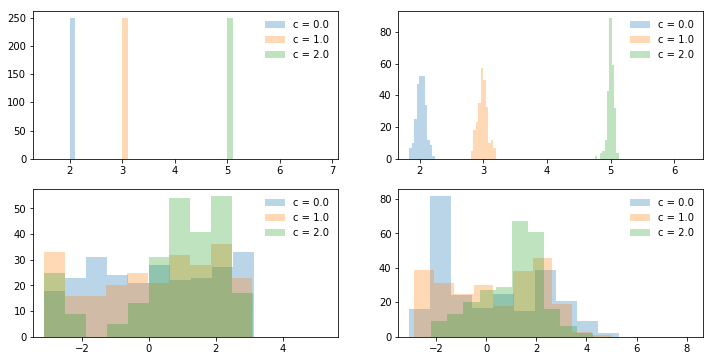

Epoch 16000 GAN loss is -1657.7562255859375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.003352165222168
Fakes (c=1.0) mean is 3.002060651779175
Fakes (c=2.0) mean is 4.9835662841796875
Data (c=0.0) mean is -0.07963382510118278
Data (c=1.0) mean is 0.28071903548922855
Data (c=2.0) mean is 1.0956670230887287
Fakes (c=0.0) mean is 0.029812024906277657
Fakes (c=1.0) mean is 0.0988323986530304
Fakes (c=2.0) mean is 1.0381537675857544


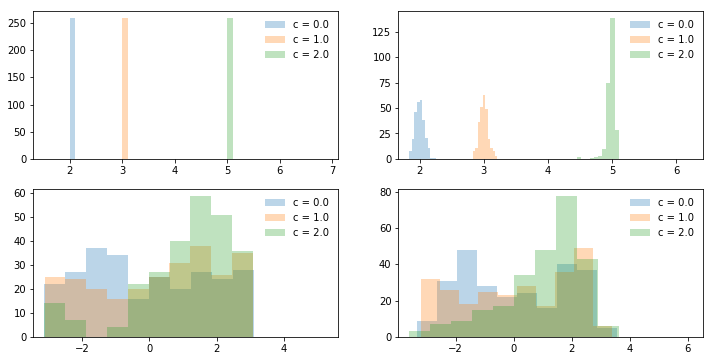

Epoch 17000 GAN loss is -1777.494140625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0082027912139893
Fakes (c=1.0) mean is 3.003042697906494
Fakes (c=2.0) mean is 5.0001702308654785
Data (c=0.0) mean is -0.3119085826913888
Data (c=1.0) mean is 0.2810106771815354
Data (c=2.0) mean is 0.7938490221451441
Fakes (c=0.0) mean is -0.12155449390411377
Fakes (c=1.0) mean is 0.13624092936515808
Fakes (c=2.0) mean is 1.1330513954162598


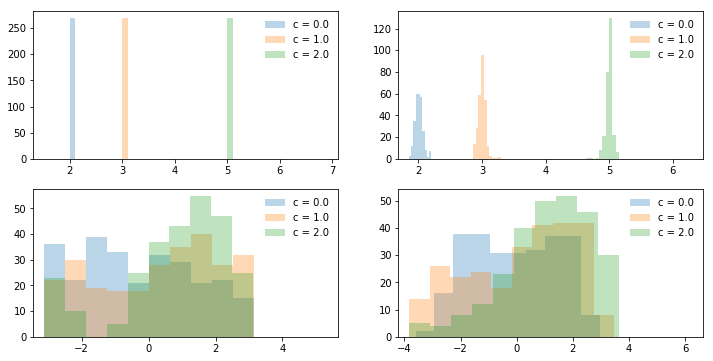

Epoch 18000 GAN loss is -1749.5169677734375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.004666566848755
Fakes (c=1.0) mean is 3.0131819248199463
Fakes (c=2.0) mean is 5.002634048461914
Data (c=0.0) mean is -0.00369295558088575
Data (c=1.0) mean is 0.07137246427764034
Data (c=2.0) mean is 0.9751148700266047
Fakes (c=0.0) mean is -0.01747124455869198
Fakes (c=1.0) mean is 0.11990277469158173
Fakes (c=2.0) mean is 1.1462023258209229


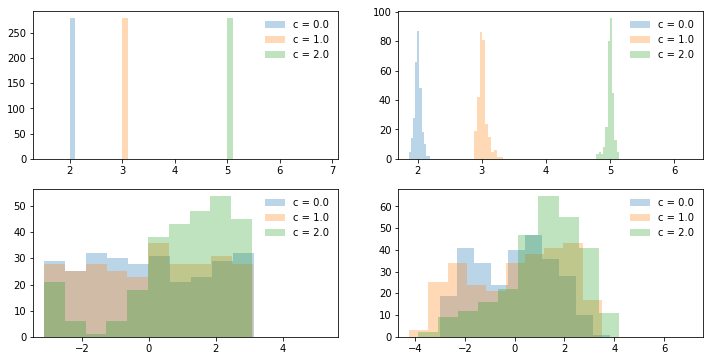

Epoch 19000 GAN loss is -1822.04296875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0004963874816895
Fakes (c=1.0) mean is 3.0215647220611572
Fakes (c=2.0) mean is 4.993388652801514
Data (c=0.0) mean is 0.10220224625368282
Data (c=1.0) mean is 0.24664053945576786
Data (c=2.0) mean is 1.0202107803966305
Fakes (c=0.0) mean is 0.09351295977830887
Fakes (c=1.0) mean is 0.1679331511259079
Fakes (c=2.0) mean is 0.9212570786476135


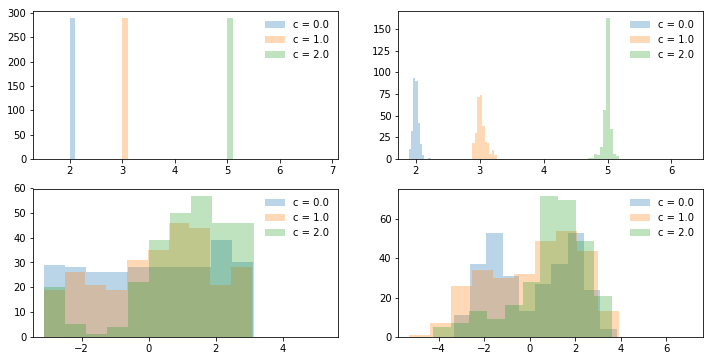

Epoch 20000 GAN loss is -1961.535888671875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.9976208209991455
Fakes (c=1.0) mean is 3.013185977935791
Fakes (c=2.0) mean is 4.985118865966797
Data (c=0.0) mean is 0.07815718244948165
Data (c=1.0) mean is 0.10598035505036338
Data (c=2.0) mean is 0.9764614126330761
Fakes (c=0.0) mean is 0.0224873349070549
Fakes (c=1.0) mean is 0.32985153794288635
Fakes (c=2.0) mean is 1.0053011178970337


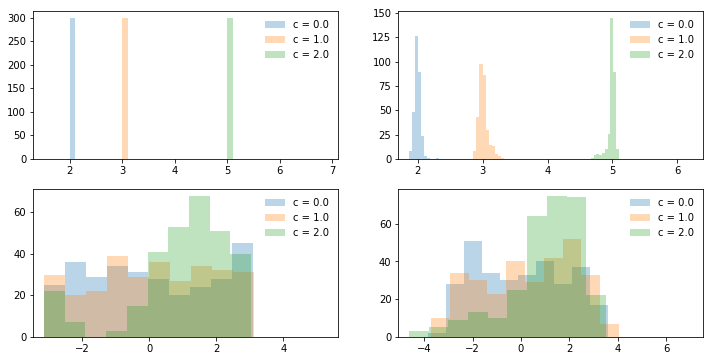

Epoch 21000 GAN loss is -2063.238525390625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.011486291885376
Fakes (c=1.0) mean is 3.014111042022705
Fakes (c=2.0) mean is 4.992750644683838
Data (c=0.0) mean is 0.021238669370931423
Data (c=1.0) mean is 0.34805336189503444
Data (c=2.0) mean is 0.8528205950260117
Fakes (c=0.0) mean is 0.012838692404329777
Fakes (c=1.0) mean is 0.1367093175649643
Fakes (c=2.0) mean is 0.9696351885795593


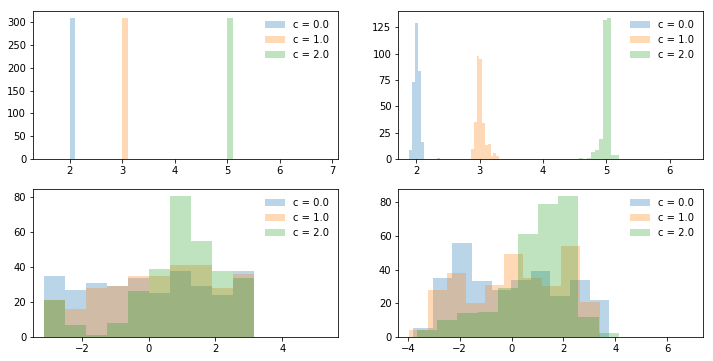

Epoch 22000 GAN loss is -2168.8466796875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0069541931152344
Fakes (c=1.0) mean is 3.0056445598602295
Fakes (c=2.0) mean is 4.981335639953613
Data (c=0.0) mean is -0.15319736510029838
Data (c=1.0) mean is -0.013245794937578825
Data (c=2.0) mean is 0.9407498338064937
Fakes (c=0.0) mean is 0.07068625092506409
Fakes (c=1.0) mean is 0.24692244827747345
Fakes (c=2.0) mean is 0.7123023867607117


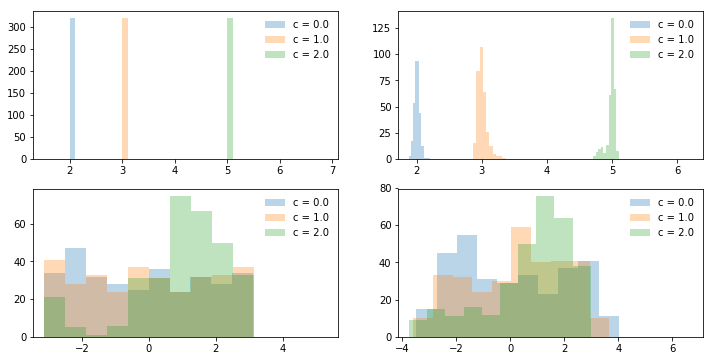

Epoch 23000 GAN loss is -2298.4853515625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.009148359298706
Fakes (c=1.0) mean is 3.010035753250122
Fakes (c=2.0) mean is 4.990394592285156
Data (c=0.0) mean is 0.09838790016114637
Data (c=1.0) mean is 0.3508173451500101
Data (c=2.0) mean is 1.0335675502324304
Fakes (c=0.0) mean is -0.03567040339112282
Fakes (c=1.0) mean is 0.24095526337623596
Fakes (c=2.0) mean is 0.9564153552055359


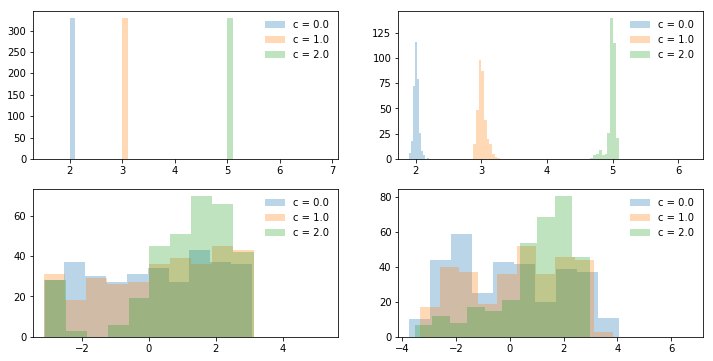

Epoch 24000 GAN loss is -2397.8017578125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.006030321121216
Fakes (c=1.0) mean is 3.007050037384033
Fakes (c=2.0) mean is 4.991944313049316
Data (c=0.0) mean is 0.18553671798588514
Data (c=1.0) mean is 0.2733348289670146
Data (c=2.0) mean is 1.103957801205491
Fakes (c=0.0) mean is 0.006037442944943905
Fakes (c=1.0) mean is 0.39095163345336914
Fakes (c=2.0) mean is 1.05903160572052


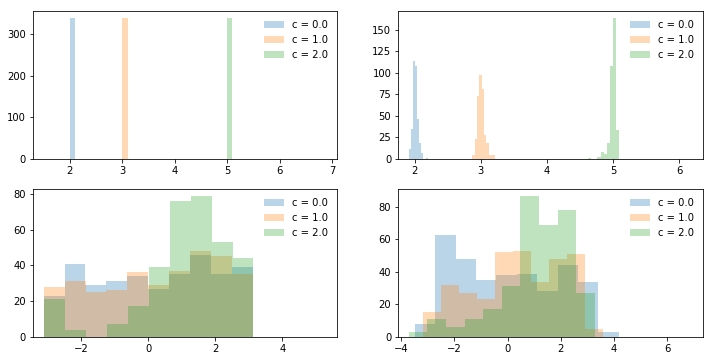

Epoch 25000 GAN loss is -2504.27880859375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0086092948913574
Fakes (c=1.0) mean is 3.0041451454162598
Fakes (c=2.0) mean is 4.986516952514648
Data (c=0.0) mean is 0.06036844138779962
Data (c=1.0) mean is 0.27386313594473133
Data (c=2.0) mean is 0.9110435503718478
Fakes (c=0.0) mean is -0.04614359140396118
Fakes (c=1.0) mean is 0.1674172580242157
Fakes (c=2.0) mean is 1.0298750400543213


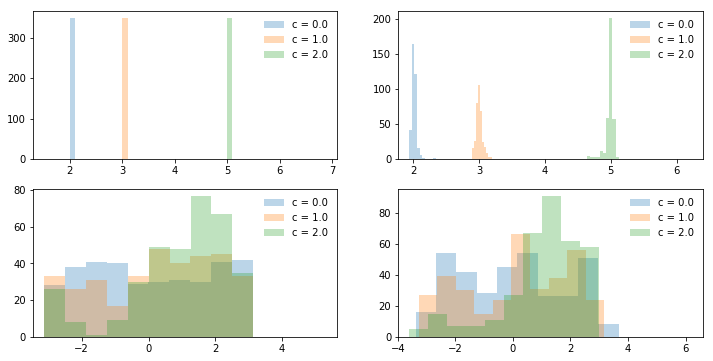

Epoch 26000 GAN loss is -2545.05078125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0052101612091064
Fakes (c=1.0) mean is 3.0040476322174072
Fakes (c=2.0) mean is 4.992179870605469
Data (c=0.0) mean is 0.00041912004257721827
Data (c=1.0) mean is 0.23024953637872783
Data (c=2.0) mean is 1.05963433240178
Fakes (c=0.0) mean is 0.10591539740562439
Fakes (c=1.0) mean is 0.24368400871753693
Fakes (c=2.0) mean is 1.0474879741668701


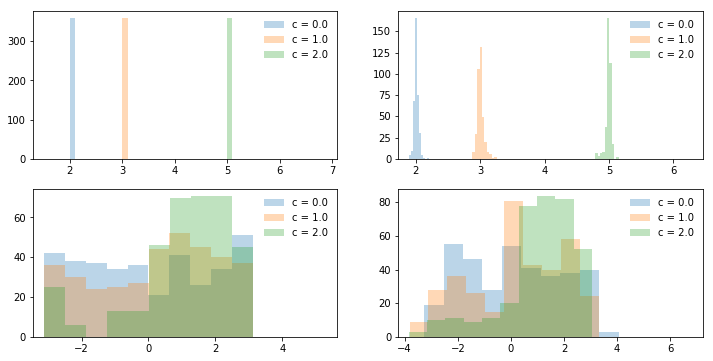

Epoch 27000 GAN loss is -2543.292236328125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0048224925994873
Fakes (c=1.0) mean is 3.0095036029815674
Fakes (c=2.0) mean is 4.991032123565674
Data (c=0.0) mean is -0.09916757381775283
Data (c=1.0) mean is 0.2560961890264864
Data (c=2.0) mean is 0.9298927319631622
Fakes (c=0.0) mean is 0.07206059247255325
Fakes (c=1.0) mean is 0.19062310457229614
Fakes (c=2.0) mean is 0.9564870595932007


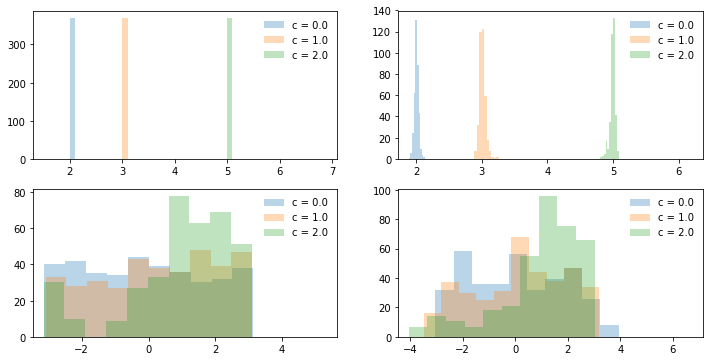

Epoch 28000 GAN loss is -2554.438232421875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.006425619125366
Fakes (c=1.0) mean is 3.006666898727417
Fakes (c=2.0) mean is 4.9905009269714355
Data (c=0.0) mean is -0.03506256103141279
Data (c=1.0) mean is 0.16837150436441492
Data (c=2.0) mean is 1.0091158228319304
Fakes (c=0.0) mean is -0.01882154494524002
Fakes (c=1.0) mean is 0.2895274758338928
Fakes (c=2.0) mean is 1.0812194347381592


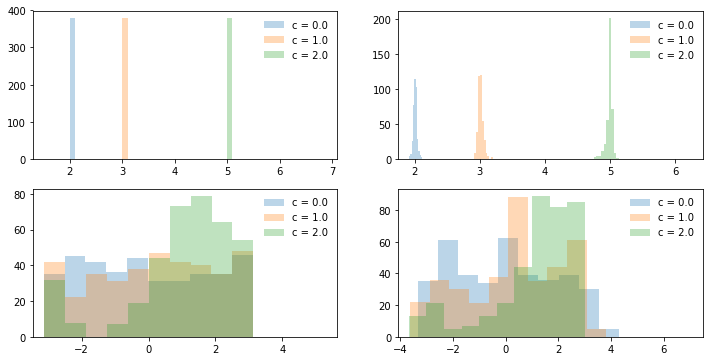

Epoch 29000 GAN loss is -2551.653564453125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0012714862823486
Fakes (c=1.0) mean is 2.9984664916992188
Fakes (c=2.0) mean is 4.992896556854248
Data (c=0.0) mean is -0.04586726179958912
Data (c=1.0) mean is 0.3516988444499732
Data (c=2.0) mean is 0.8216840694268764
Fakes (c=0.0) mean is 0.06924685090780258
Fakes (c=1.0) mean is 0.19229893386363983
Fakes (c=2.0) mean is 1.0370993614196777


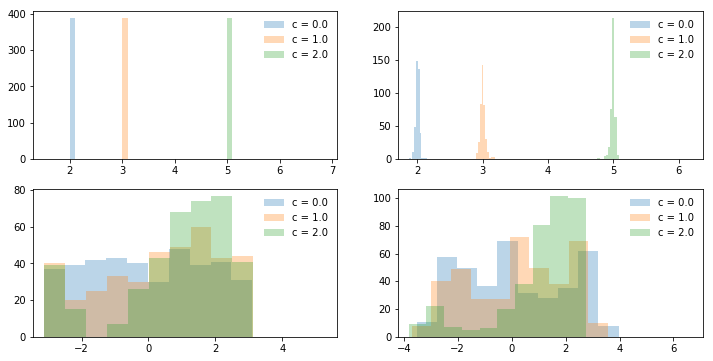

Epoch 30000 GAN loss is -2552.091064453125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0067639350891113
Fakes (c=1.0) mean is 3.0010979175567627
Fakes (c=2.0) mean is 4.9938201904296875
Data (c=0.0) mean is 0.03497203037610393
Data (c=1.0) mean is 0.24649899891561033
Data (c=2.0) mean is 1.1227635856315552
Fakes (c=0.0) mean is -0.03494495525956154
Fakes (c=1.0) mean is 0.2826399505138397
Fakes (c=2.0) mean is 1.1030116081237793


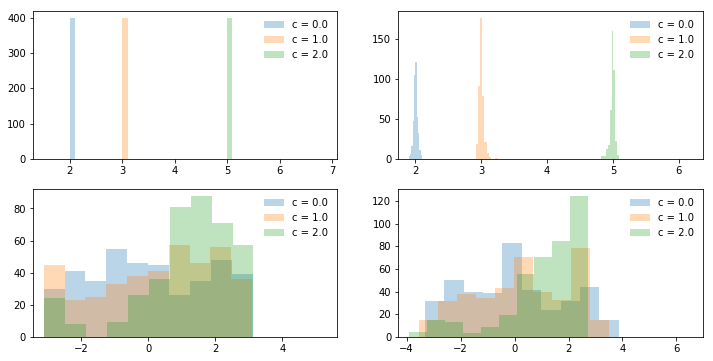

Epoch 31000 GAN loss is -2486.177490234375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0063958168029785
Fakes (c=1.0) mean is 2.995556354522705
Fakes (c=2.0) mean is 4.994207859039307
Data (c=0.0) mean is 0.17704868048821104
Data (c=1.0) mean is 0.23739811058696023
Data (c=2.0) mean is 1.139732785548017
Fakes (c=0.0) mean is -0.20923815667629242
Fakes (c=1.0) mean is 0.3700519800186157
Fakes (c=2.0) mean is 1.050553798675537


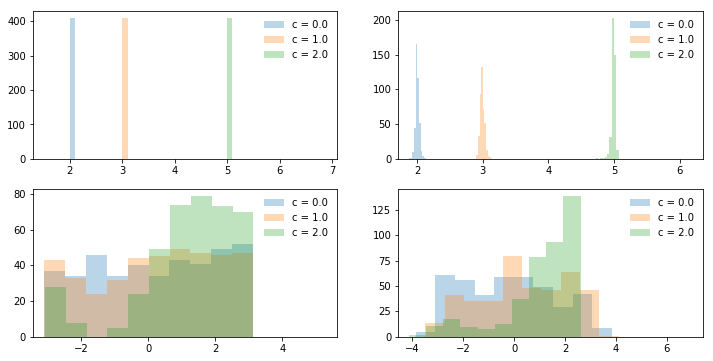

Epoch 32000 GAN loss is -2463.096435546875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0062012672424316
Fakes (c=1.0) mean is 2.995354175567627
Fakes (c=2.0) mean is 4.989416122436523
Data (c=0.0) mean is -0.021915106889806704
Data (c=1.0) mean is 0.14278751176074395
Data (c=2.0) mean is 1.0018777281245383
Fakes (c=0.0) mean is -0.13972097635269165
Fakes (c=1.0) mean is 0.2712365984916687
Fakes (c=2.0) mean is 0.8559815883636475


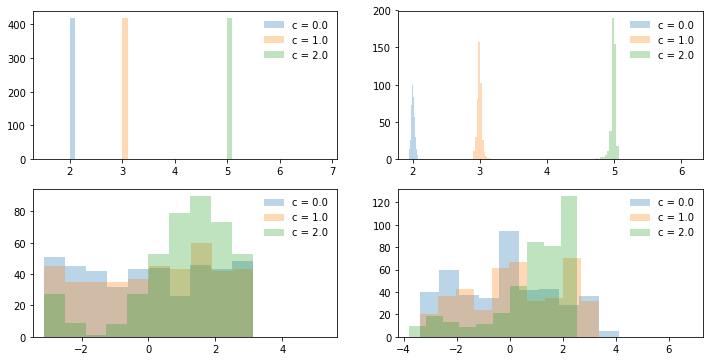

Epoch 33000 GAN loss is -2446.10400390625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0065484046936035
Fakes (c=1.0) mean is 2.995939254760742
Fakes (c=2.0) mean is 4.992474555969238
Data (c=0.0) mean is 0.14586802923554346
Data (c=1.0) mean is 0.0627272256724558
Data (c=2.0) mean is 0.8868345730878116
Fakes (c=0.0) mean is -0.015321598388254642
Fakes (c=1.0) mean is 0.30253082513809204
Fakes (c=2.0) mean is 0.9770786762237549


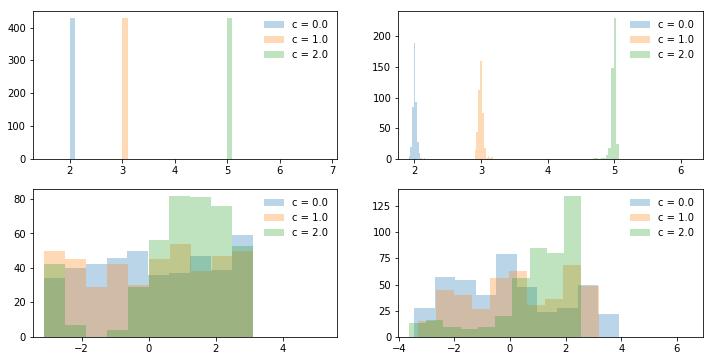

Epoch 34000 GAN loss is -2445.072021484375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0098013877868652
Fakes (c=1.0) mean is 2.9946393966674805
Fakes (c=2.0) mean is 4.994246482849121
Data (c=0.0) mean is 0.09686557946405298
Data (c=1.0) mean is 0.19791382127674004
Data (c=2.0) mean is 0.9213815679318959
Fakes (c=0.0) mean is 0.050674811005592346
Fakes (c=1.0) mean is 0.16261592507362366
Fakes (c=2.0) mean is 0.977802574634552


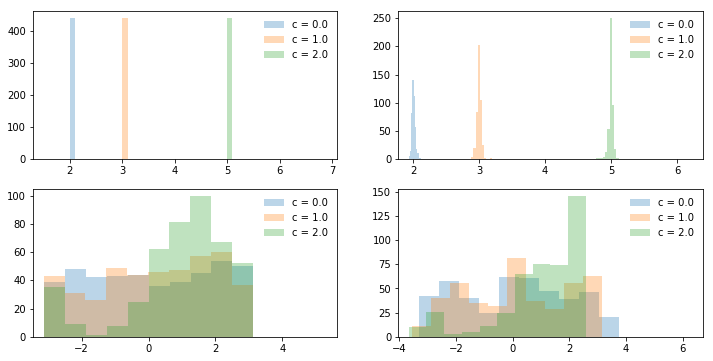

Epoch 35000 GAN loss is -2493.37255859375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0113213062286377
Fakes (c=1.0) mean is 2.995797872543335
Fakes (c=2.0) mean is 4.998201847076416
Data (c=0.0) mean is 0.05605978044803942
Data (c=1.0) mean is 0.31956592750348517
Data (c=2.0) mean is 1.024463145398535
Fakes (c=0.0) mean is -0.0023934682831168175
Fakes (c=1.0) mean is 0.1697622388601303
Fakes (c=2.0) mean is 0.9265674948692322


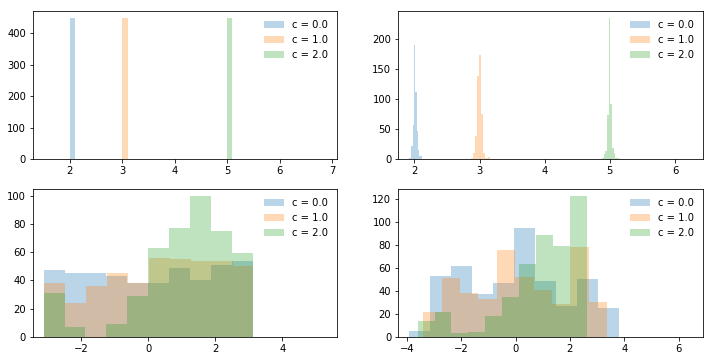

Epoch 36000 GAN loss is -2550.34619140625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.010850191116333
Fakes (c=1.0) mean is 2.9953415393829346
Fakes (c=2.0) mean is 4.993043899536133
Data (c=0.0) mean is 0.18747687456044126
Data (c=1.0) mean is 0.2610563687161708
Data (c=2.0) mean is 0.9460860153418208
Fakes (c=0.0) mean is 0.11821594834327698
Fakes (c=1.0) mean is 0.16640253365039825
Fakes (c=2.0) mean is 1.0514233112335205


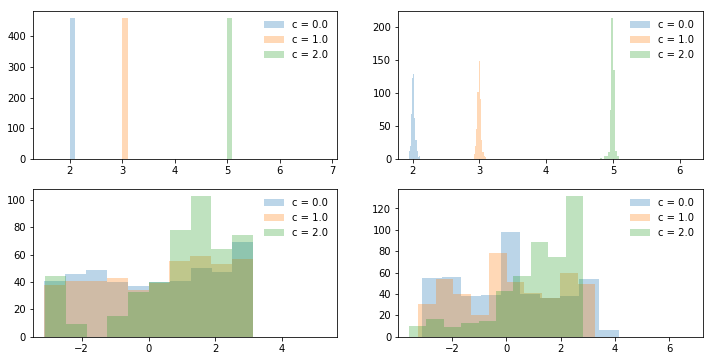

Epoch 37000 GAN loss is -2602.8662109375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0082645416259766
Fakes (c=1.0) mean is 2.995013475418091
Fakes (c=2.0) mean is 4.995622158050537
Data (c=0.0) mean is 0.0944811747080347
Data (c=1.0) mean is 0.3183966308796896
Data (c=2.0) mean is 0.9729322475802066
Fakes (c=0.0) mean is 0.025684688240289688
Fakes (c=1.0) mean is 0.3020727336406708
Fakes (c=2.0) mean is 0.9841715097427368


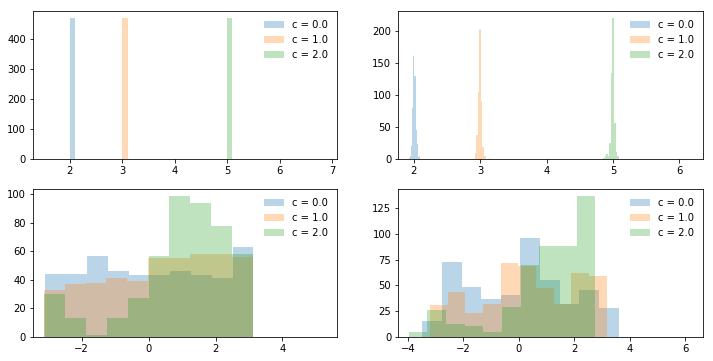

Epoch 38000 GAN loss is -2714.33544921875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.009761333465576
Fakes (c=1.0) mean is 2.994920015335083
Fakes (c=2.0) mean is 4.995709419250488
Data (c=0.0) mean is 0.02190335598957372
Data (c=1.0) mean is 0.26034962854699095
Data (c=2.0) mean is 0.9452817930320143
Fakes (c=0.0) mean is 0.23430290818214417
Fakes (c=1.0) mean is 0.2238098829984665
Fakes (c=2.0) mean is 0.9929742217063904


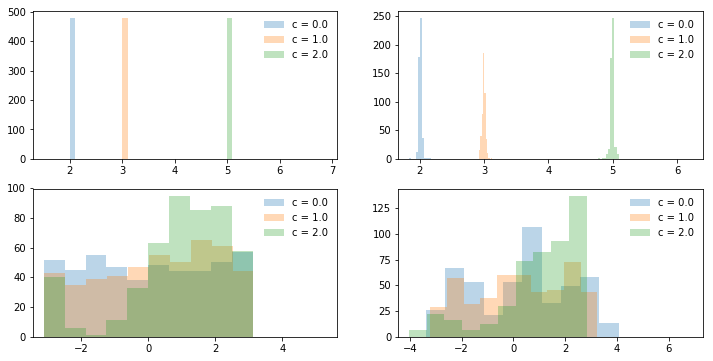

Epoch 39000 GAN loss is -2802.09228515625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.01178240776062
Fakes (c=1.0) mean is 2.995002508163452
Fakes (c=2.0) mean is 4.996377944946289
Data (c=0.0) mean is -0.12102912568774794
Data (c=1.0) mean is 0.18227256338385017
Data (c=2.0) mean is 0.9939227789775608
Fakes (c=0.0) mean is 0.11868717521429062
Fakes (c=1.0) mean is 0.1402227133512497
Fakes (c=2.0) mean is 1.0385993719100952


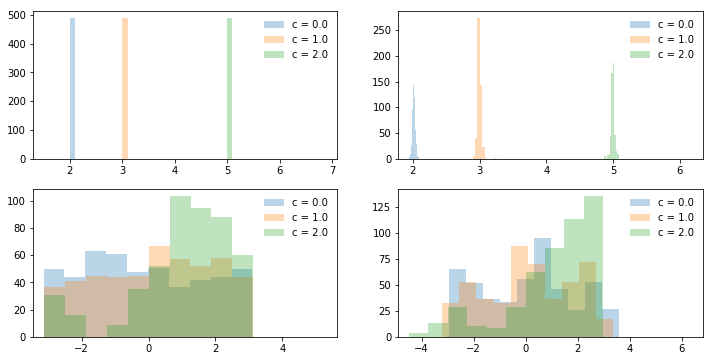

Epoch 40000 GAN loss is -2922.625244140625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.00728702545166
Fakes (c=1.0) mean is 2.9918785095214844
Fakes (c=2.0) mean is 4.991621494293213
Data (c=0.0) mean is -0.12999435527977085
Data (c=1.0) mean is 0.16261815411618785
Data (c=2.0) mean is 0.9775473669842568
Fakes (c=0.0) mean is -0.14168526232242584
Fakes (c=1.0) mean is 0.1278432309627533
Fakes (c=2.0) mean is 1.0977001190185547


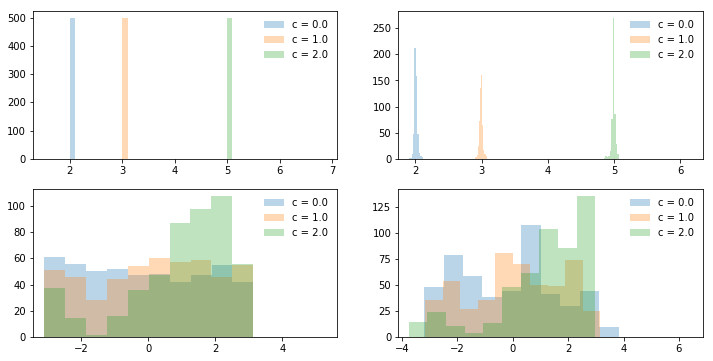

Epoch 41000 GAN loss is -3035.757080078125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.008842945098877
Fakes (c=1.0) mean is 2.9923593997955322
Fakes (c=2.0) mean is 4.995872497558594
Data (c=0.0) mean is -0.1084506449637534
Data (c=1.0) mean is 0.3052181553837875
Data (c=2.0) mean is 0.860951805062749
Fakes (c=0.0) mean is 0.1627199649810791
Fakes (c=1.0) mean is 0.134266659617424
Fakes (c=2.0) mean is 1.1136807203292847


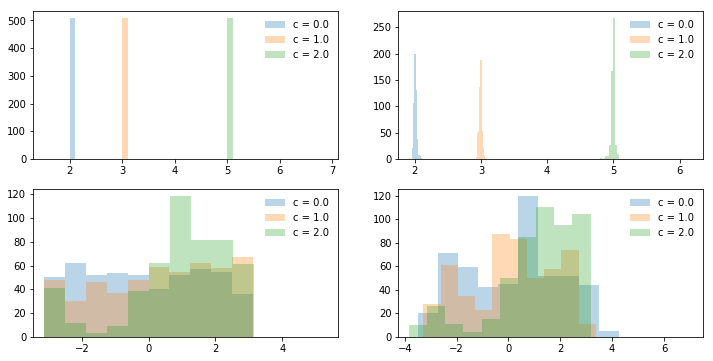

Epoch 42000 GAN loss is -3148.1806640625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.008923292160034
Fakes (c=1.0) mean is 2.9948482513427734
Fakes (c=2.0) mean is 4.99945068359375
Data (c=0.0) mean is 0.07818752764523176
Data (c=1.0) mean is 0.27662448483830393
Data (c=2.0) mean is 0.9555019933561021
Fakes (c=0.0) mean is 0.20346932113170624
Fakes (c=1.0) mean is 0.08713839948177338
Fakes (c=2.0) mean is 0.9292004704475403


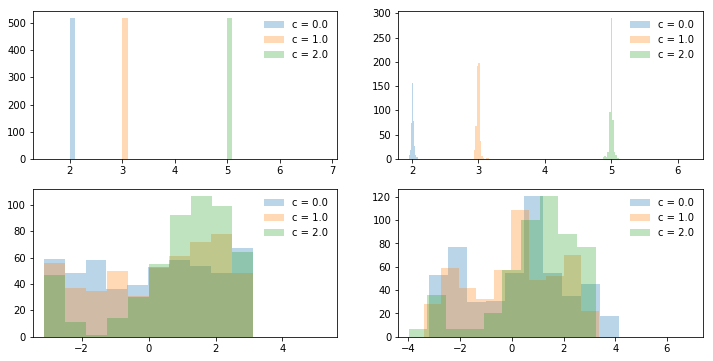

Epoch 43000 GAN loss is -3197.943603515625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0108108520507812
Fakes (c=1.0) mean is 2.9935247898101807
Fakes (c=2.0) mean is 4.9936957359313965
Data (c=0.0) mean is -0.0067502072804213565
Data (c=1.0) mean is 0.20531965898069732
Data (c=2.0) mean is 1.0358327742412312
Fakes (c=0.0) mean is 0.1464329957962036
Fakes (c=1.0) mean is 0.22566621005535126
Fakes (c=2.0) mean is 1.0463210344314575


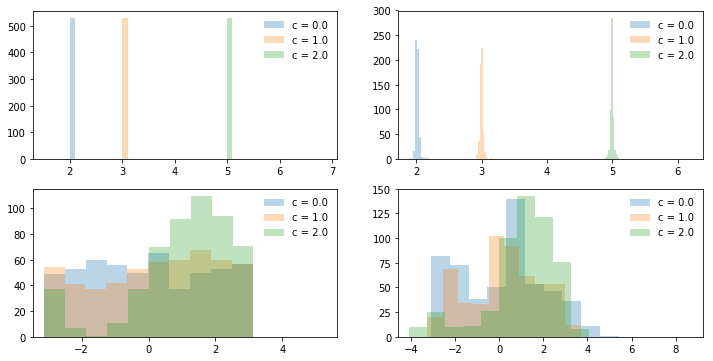

Epoch 44000 GAN loss is -3307.001220703125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0055196285247803
Fakes (c=1.0) mean is 2.991220474243164
Fakes (c=2.0) mean is 4.993635177612305
Data (c=0.0) mean is -0.033396210227104976
Data (c=1.0) mean is 0.24553694362555661
Data (c=2.0) mean is 0.9639071156469792
Fakes (c=0.0) mean is 0.21700981259346008
Fakes (c=1.0) mean is 0.2217445969581604
Fakes (c=2.0) mean is 1.025985598564148


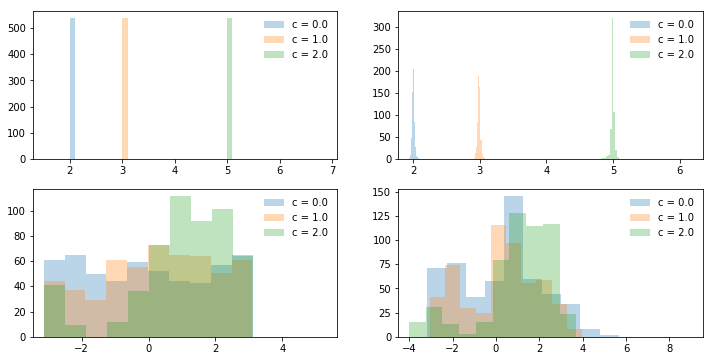

Epoch 45000 GAN loss is -3387.642822265625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.012145757675171
Fakes (c=1.0) mean is 2.9997074604034424
Fakes (c=2.0) mean is 5.003711223602295
Data (c=0.0) mean is -0.030567053505497502
Data (c=1.0) mean is 0.22183697797804874
Data (c=2.0) mean is 0.9564322266074594
Fakes (c=0.0) mean is 0.10176416486501694
Fakes (c=1.0) mean is 0.22670158743858337
Fakes (c=2.0) mean is 1.0909591913223267


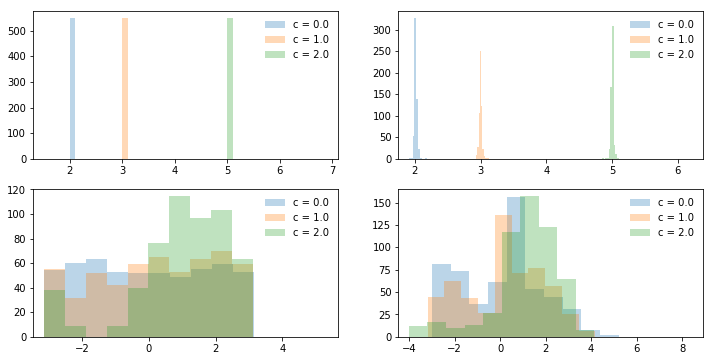

Epoch 46000 GAN loss is -3486.955322265625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.008483648300171
Fakes (c=1.0) mean is 2.9936976432800293
Fakes (c=2.0) mean is 4.9948625564575195
Data (c=0.0) mean is -0.027439619159841864
Data (c=1.0) mean is 0.2827115085316887
Data (c=2.0) mean is 0.98836559976541
Fakes (c=0.0) mean is 0.16407684981822968
Fakes (c=1.0) mean is 0.15136678516864777
Fakes (c=2.0) mean is 1.0597460269927979


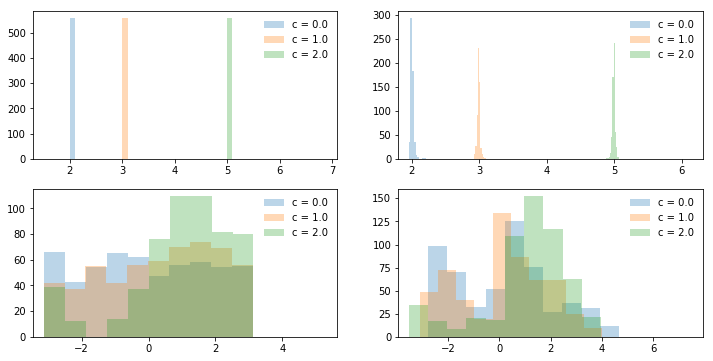

Epoch 47000 GAN loss is -3571.56689453125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.007756471633911
Fakes (c=1.0) mean is 2.9973883628845215
Fakes (c=2.0) mean is 5.000376224517822
Data (c=0.0) mean is -0.03659757484338537
Data (c=1.0) mean is 0.19684277692846058
Data (c=2.0) mean is 0.9735205464564319
Fakes (c=0.0) mean is 0.19850829243659973
Fakes (c=1.0) mean is 0.313044935464859
Fakes (c=2.0) mean is 0.9929674863815308


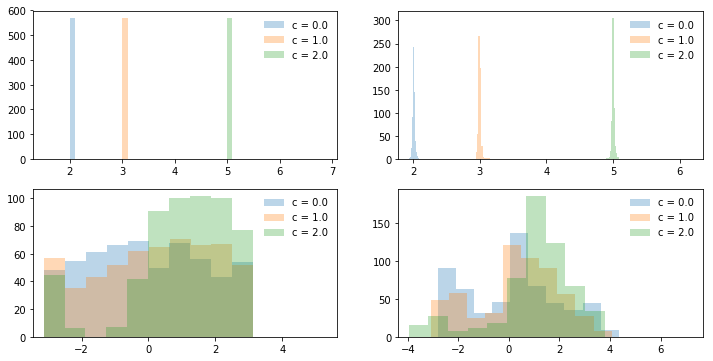

Epoch 48000 GAN loss is -3644.89453125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0110321044921875
Fakes (c=1.0) mean is 3.004774570465088
Fakes (c=2.0) mean is 5.005692481994629
Data (c=0.0) mean is -0.007267489188378004
Data (c=1.0) mean is 0.34115784105923325
Data (c=2.0) mean is 0.9842611480649934
Fakes (c=0.0) mean is -0.06633404642343521
Fakes (c=1.0) mean is 0.21761304140090942
Fakes (c=2.0) mean is 1.005411982536316


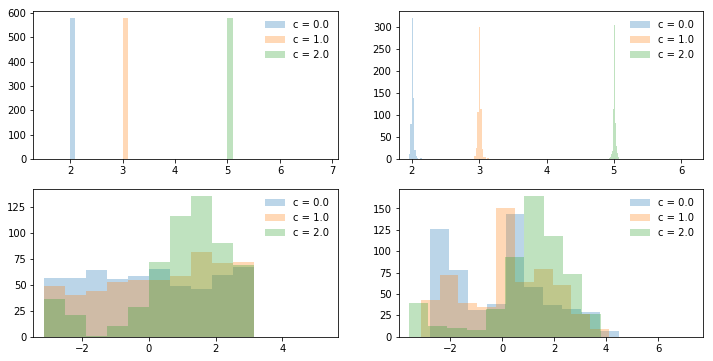

Epoch 49000 GAN loss is -3728.55859375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.007075548171997
Fakes (c=1.0) mean is 2.9993460178375244
Fakes (c=2.0) mean is 4.997093677520752
Data (c=0.0) mean is 0.04295150724906654
Data (c=1.0) mean is 0.1937263855657411
Data (c=2.0) mean is 1.041717792532428
Fakes (c=0.0) mean is 0.02096625231206417
Fakes (c=1.0) mean is 0.22823466360569
Fakes (c=2.0) mean is 1.1067373752593994


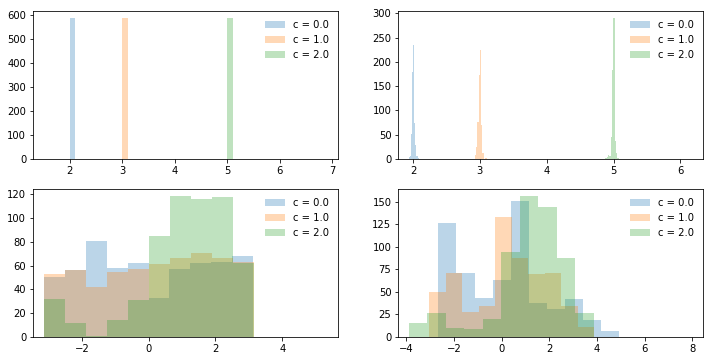

Epoch 50000 GAN loss is -3759.480712890625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.007108211517334
Fakes (c=1.0) mean is 2.997366428375244
Fakes (c=2.0) mean is 4.996290683746338
Data (c=0.0) mean is 0.1158610875133302
Data (c=1.0) mean is 0.25174180926406203
Data (c=2.0) mean is 1.050230291148919
Fakes (c=0.0) mean is 0.09587094932794571
Fakes (c=1.0) mean is 0.1727725863456726
Fakes (c=2.0) mean is 1.0788233280181885


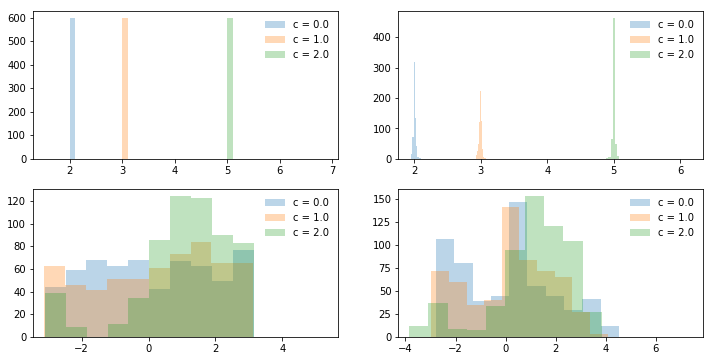

Epoch 51000 GAN loss is -3804.543701171875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.006162166595459
Fakes (c=1.0) mean is 2.9985671043395996
Fakes (c=2.0) mean is 4.998844146728516
Data (c=0.0) mean is 0.026178368027707302
Data (c=1.0) mean is 0.18412538676994702
Data (c=2.0) mean is 0.8201534301348498
Fakes (c=0.0) mean is 0.09564199298620224
Fakes (c=1.0) mean is 0.07550907135009766
Fakes (c=2.0) mean is 1.1440850496292114


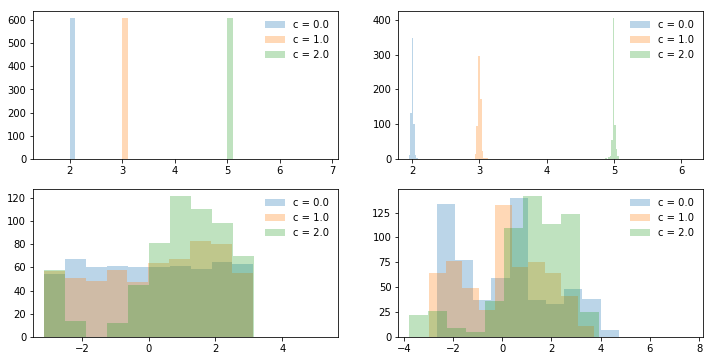

Epoch 52000 GAN loss is -3835.014892578125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0079596042633057
Fakes (c=1.0) mean is 2.9995360374450684
Fakes (c=2.0) mean is 4.994725704193115
Data (c=0.0) mean is -0.003173136892431029
Data (c=1.0) mean is 0.2657475006900145
Data (c=2.0) mean is 1.073325632411778
Fakes (c=0.0) mean is -0.047838881611824036
Fakes (c=1.0) mean is 0.20452146232128143
Fakes (c=2.0) mean is 1.1775215864181519


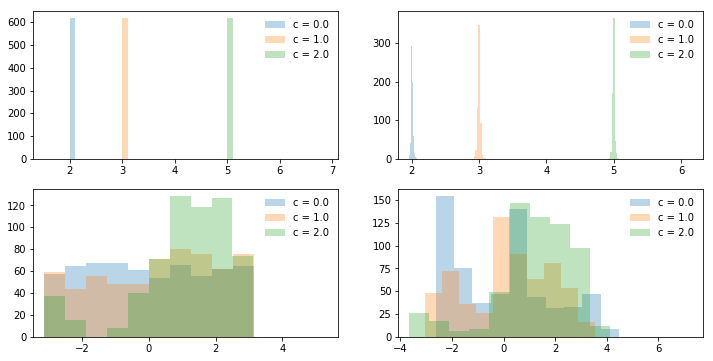

Epoch 53000 GAN loss is -3866.017822265625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0053350925445557
Fakes (c=1.0) mean is 2.997925281524658
Fakes (c=2.0) mean is 4.993926525115967
Data (c=0.0) mean is -0.005533554317984454
Data (c=1.0) mean is 0.14994963741832143
Data (c=2.0) mean is 0.9464251492079493
Fakes (c=0.0) mean is 0.14016491174697876
Fakes (c=1.0) mean is 0.29964521527290344
Fakes (c=2.0) mean is 1.1039588451385498


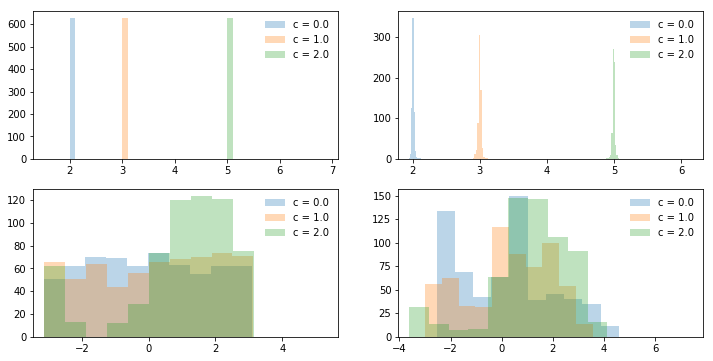

Epoch 54000 GAN loss is -3851.624755859375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.004129648208618
Fakes (c=1.0) mean is 2.997614622116089
Fakes (c=2.0) mean is 4.99692440032959
Data (c=0.0) mean is 0.0665895482416471
Data (c=1.0) mean is 0.2778150977140291
Data (c=2.0) mean is 0.8924082789685006
Fakes (c=0.0) mean is 0.2320757359266281
Fakes (c=1.0) mean is 0.1614510416984558
Fakes (c=2.0) mean is 0.9368947744369507


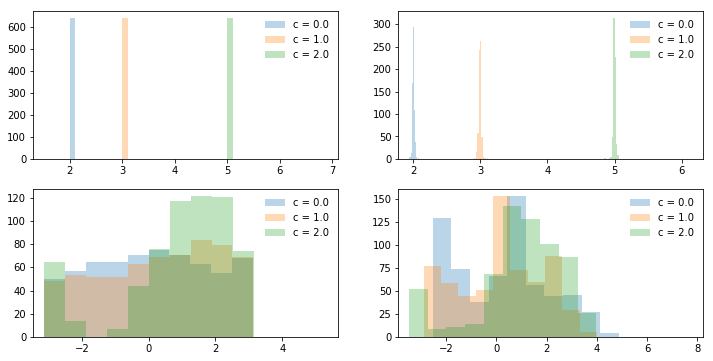

Epoch 55000 GAN loss is -3854.12548828125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0085904598236084
Fakes (c=1.0) mean is 3.001147985458374
Fakes (c=2.0) mean is 4.999502658843994
Data (c=0.0) mean is 0.11680018630894323
Data (c=1.0) mean is 0.1859590961499554
Data (c=2.0) mean is 1.0604458059288517
Fakes (c=0.0) mean is -0.02674972452223301
Fakes (c=1.0) mean is 0.05114097148180008
Fakes (c=2.0) mean is 1.0691097974777222


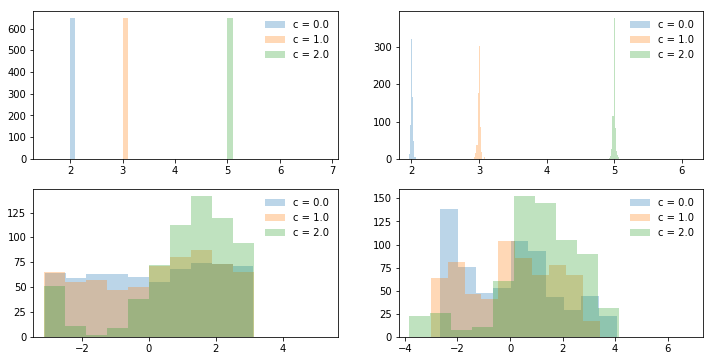

Epoch 56000 GAN loss is -3829.358642578125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0066606998443604
Fakes (c=1.0) mean is 3.0036609172821045
Fakes (c=2.0) mean is 4.998488426208496
Data (c=0.0) mean is -0.025843611143013385
Data (c=1.0) mean is 0.25202898284651526
Data (c=2.0) mean is 0.9551243134085728
Fakes (c=0.0) mean is 0.14879672229290009
Fakes (c=1.0) mean is 0.22002699971199036
Fakes (c=2.0) mean is 1.1033554077148438


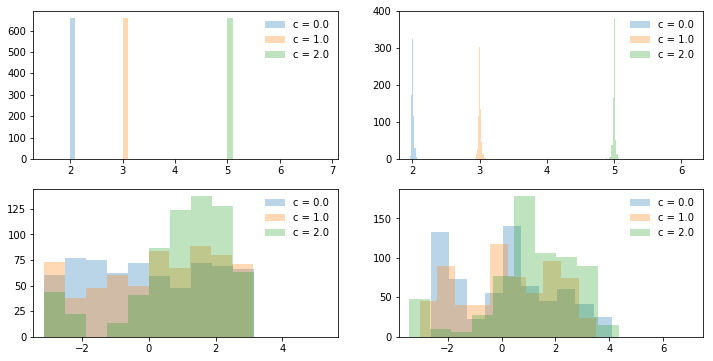

Epoch 57000 GAN loss is -3935.8134765625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.006016492843628
Fakes (c=1.0) mean is 3.0022668838500977
Fakes (c=2.0) mean is 4.998206615447998
Data (c=0.0) mean is 0.03613136907695471
Data (c=1.0) mean is 0.3301901620240005
Data (c=2.0) mean is 0.990022582937515
Fakes (c=0.0) mean is -0.02990906871855259
Fakes (c=1.0) mean is 0.18654848635196686
Fakes (c=2.0) mean is 1.0635195970535278


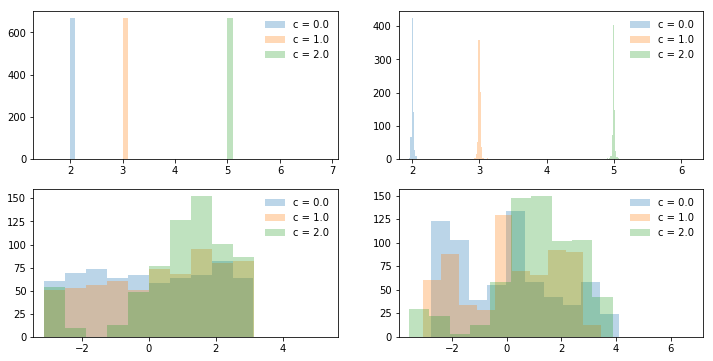

Epoch 58000 GAN loss is -4032.809326171875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.007695198059082
Fakes (c=1.0) mean is 3.0036559104919434
Fakes (c=2.0) mean is 4.998508453369141
Data (c=0.0) mean is -0.03117299540702219
Data (c=1.0) mean is 0.2663509192878722
Data (c=2.0) mean is 1.0259610989220298
Fakes (c=0.0) mean is 0.033088814467191696
Fakes (c=1.0) mean is 0.2632169723510742
Fakes (c=2.0) mean is 1.0303454399108887


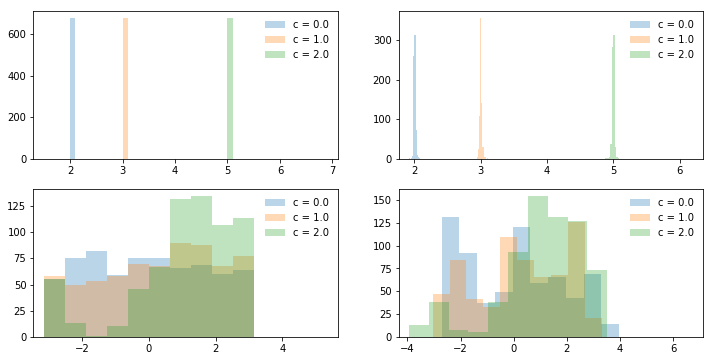

Epoch 59000 GAN loss is -3945.3115234375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.007438898086548
Fakes (c=1.0) mean is 3.001230239868164
Fakes (c=2.0) mean is 4.995416641235352
Data (c=0.0) mean is -0.09900828932773201
Data (c=1.0) mean is 0.052479255778369226
Data (c=2.0) mean is 0.9335381615093236
Fakes (c=0.0) mean is 0.029873980209231377
Fakes (c=1.0) mean is 0.19731789827346802
Fakes (c=2.0) mean is 0.9745662808418274


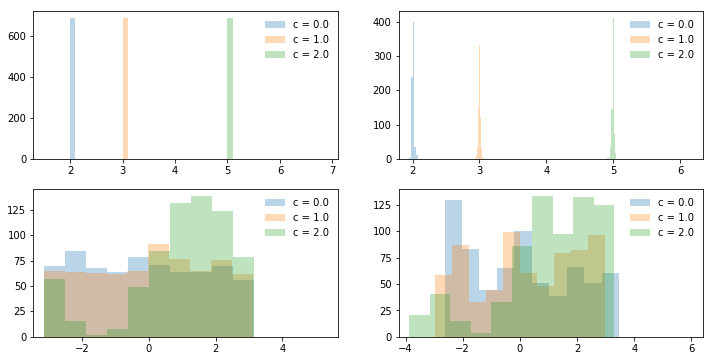

Epoch 60000 GAN loss is -4009.07470703125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0053930282592773
Fakes (c=1.0) mean is 3.002967596054077
Fakes (c=2.0) mean is 5.00123929977417
Data (c=0.0) mean is -0.04557169611998412
Data (c=1.0) mean is 0.2296425859802626
Data (c=2.0) mean is 1.0238502461573364
Fakes (c=0.0) mean is 0.17672888934612274
Fakes (c=1.0) mean is 0.14244502782821655
Fakes (c=2.0) mean is 1.0655522346496582


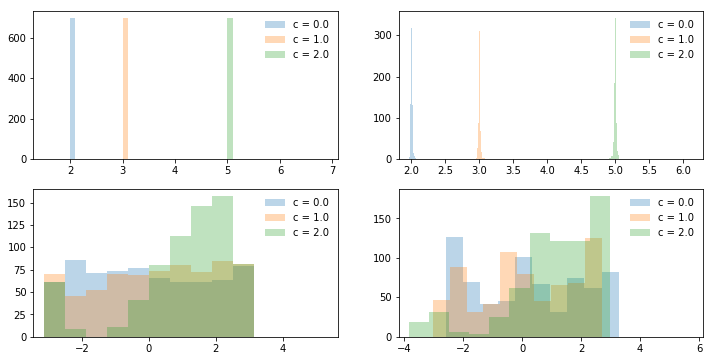

Epoch 61000 GAN loss is -4203.79443359375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0032224655151367
Fakes (c=1.0) mean is 2.9989700317382812
Fakes (c=2.0) mean is 4.995386600494385
Data (c=0.0) mean is -0.02231203089631935
Data (c=1.0) mean is 0.32774291825669133
Data (c=2.0) mean is 0.9784453593220994
Fakes (c=0.0) mean is 0.19331267476081848
Fakes (c=1.0) mean is 0.12282752245664597
Fakes (c=2.0) mean is 0.8554238677024841


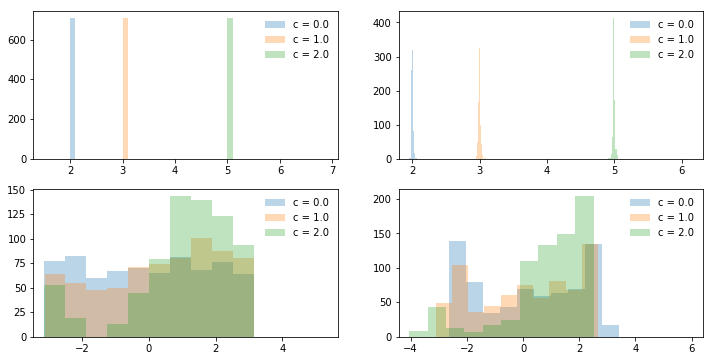

Epoch 62000 GAN loss is -4187.20654296875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0017452239990234
Fakes (c=1.0) mean is 2.9986212253570557
Fakes (c=2.0) mean is 4.992926597595215
Data (c=0.0) mean is 0.0021726263369466568
Data (c=1.0) mean is 0.15895233845861892
Data (c=2.0) mean is 0.8669383914964909
Fakes (c=0.0) mean is 0.10256559401750565
Fakes (c=1.0) mean is 0.23791652917861938
Fakes (c=2.0) mean is 1.0308648347854614


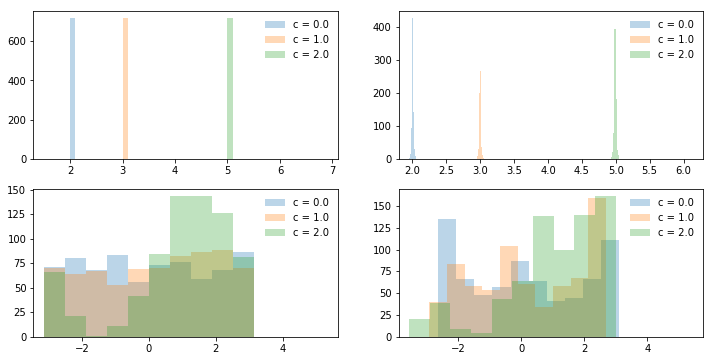

Epoch 63000 GAN loss is -4249.45703125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0034103393554688
Fakes (c=1.0) mean is 3.0032358169555664
Fakes (c=2.0) mean is 5.002420425415039
Data (c=0.0) mean is 0.06497736920236045
Data (c=1.0) mean is 0.28140643952222005
Data (c=2.0) mean is 0.979368821534544
Fakes (c=0.0) mean is -0.1393715888261795
Fakes (c=1.0) mean is 0.2480098009109497
Fakes (c=2.0) mean is 1.049778699874878


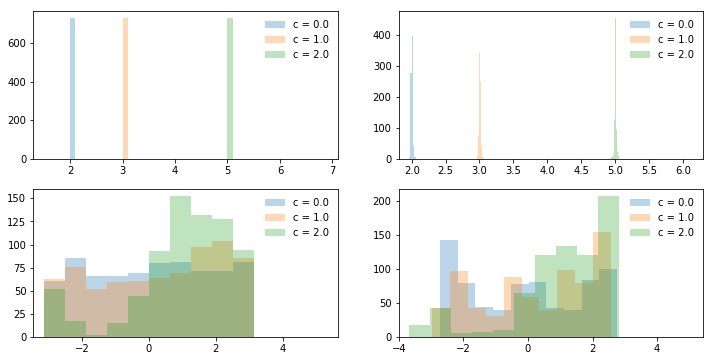

Epoch 64000 GAN loss is -4674.76220703125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0025033950805664
Fakes (c=1.0) mean is 3.000279664993286
Fakes (c=2.0) mean is 4.995152950286865
Data (c=0.0) mean is 0.06157472945632834
Data (c=1.0) mean is 0.3198658309713827
Data (c=2.0) mean is 0.8833225795490415
Fakes (c=0.0) mean is 0.03705112636089325
Fakes (c=1.0) mean is 0.15675950050354004
Fakes (c=2.0) mean is 0.9635605216026306


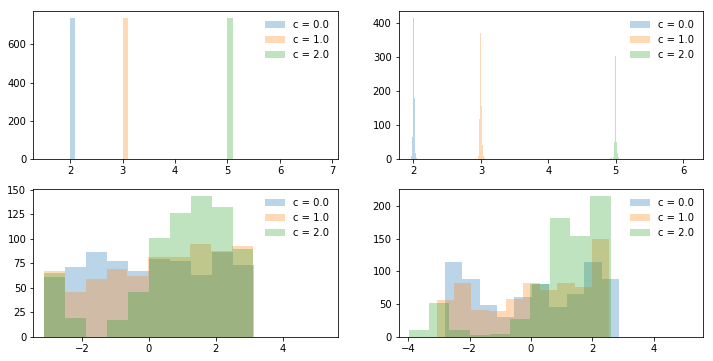

Epoch 65000 GAN loss is -4837.4541015625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.002347707748413
Fakes (c=1.0) mean is 2.9997851848602295
Fakes (c=2.0) mean is 4.996180534362793
Data (c=0.0) mean is -0.01916931422611762
Data (c=1.0) mean is 0.36589912887318965
Data (c=2.0) mean is 1.0016761700962196
Fakes (c=0.0) mean is -0.011411392129957676
Fakes (c=1.0) mean is 0.135674849152565
Fakes (c=2.0) mean is 1.0837233066558838


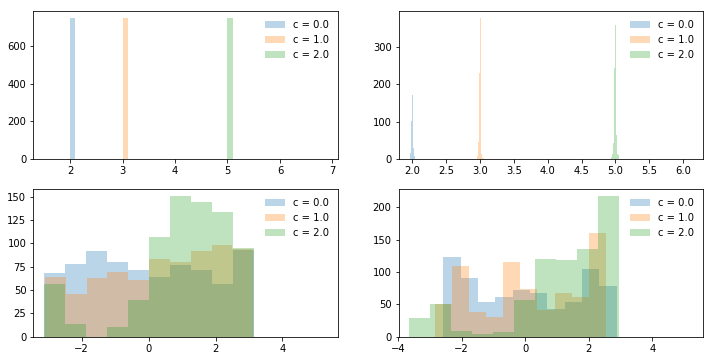

Epoch 66000 GAN loss is -4791.50048828125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0047202110290527
Fakes (c=1.0) mean is 3.000399589538574
Fakes (c=2.0) mean is 4.99596643447876
Data (c=0.0) mean is 0.014098191064516373
Data (c=1.0) mean is 0.2767029563579237
Data (c=2.0) mean is 0.947366267250008
Fakes (c=0.0) mean is 0.017321156337857246
Fakes (c=1.0) mean is 0.10084683448076248
Fakes (c=2.0) mean is 1.0664477348327637


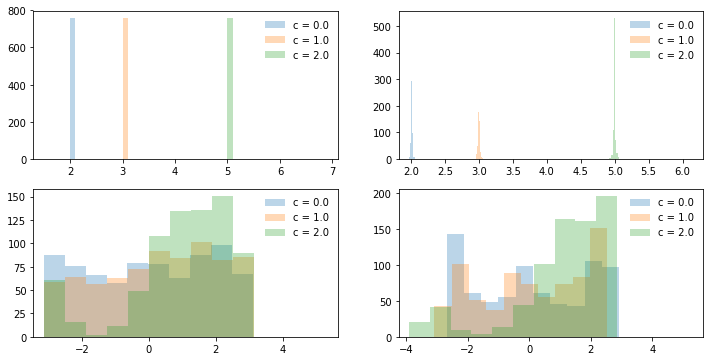

Epoch 67000 GAN loss is -4967.04296875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.003178358078003
Fakes (c=1.0) mean is 3.0014781951904297
Fakes (c=2.0) mean is 4.9990668296813965
Data (c=0.0) mean is -0.07379760708322942
Data (c=1.0) mean is 0.22236591763185604
Data (c=2.0) mean is 1.0116747924010894
Fakes (c=0.0) mean is 0.037913814187049866
Fakes (c=1.0) mean is 0.17790479958057404
Fakes (c=2.0) mean is 0.9594272375106812


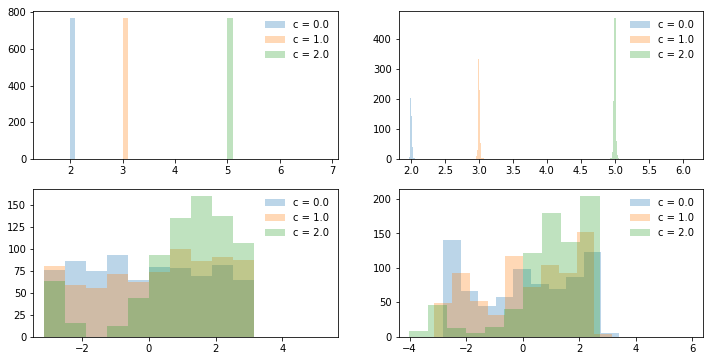

Epoch 68000 GAN loss is -4983.7861328125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0028817653656006
Fakes (c=1.0) mean is 3.0002899169921875
Fakes (c=2.0) mean is 4.996984958648682
Data (c=0.0) mean is -0.02103096049307726
Data (c=1.0) mean is 0.25955859787868
Data (c=2.0) mean is 0.9633226592508815
Fakes (c=0.0) mean is -0.06460235267877579
Fakes (c=1.0) mean is 0.10861316323280334
Fakes (c=2.0) mean is 1.1445918083190918


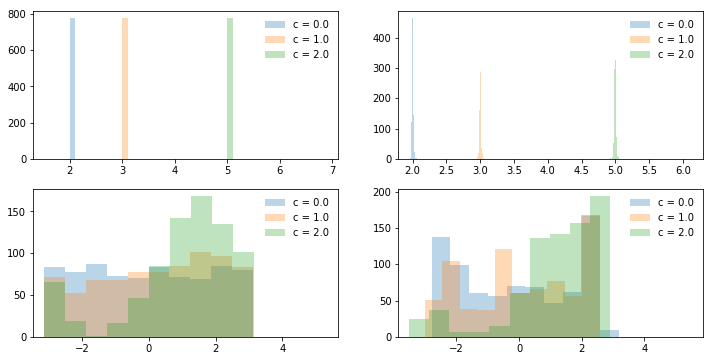

Epoch 69000 GAN loss is -4843.4892578125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0040342807769775
Fakes (c=1.0) mean is 3.0015220642089844
Fakes (c=2.0) mean is 4.997525215148926
Data (c=0.0) mean is 0.015360366007915127
Data (c=1.0) mean is 0.22396995433193786
Data (c=2.0) mean is 1.0282685737167736
Fakes (c=0.0) mean is 0.1461736559867859
Fakes (c=1.0) mean is 0.22281143069267273
Fakes (c=2.0) mean is 1.010353446006775


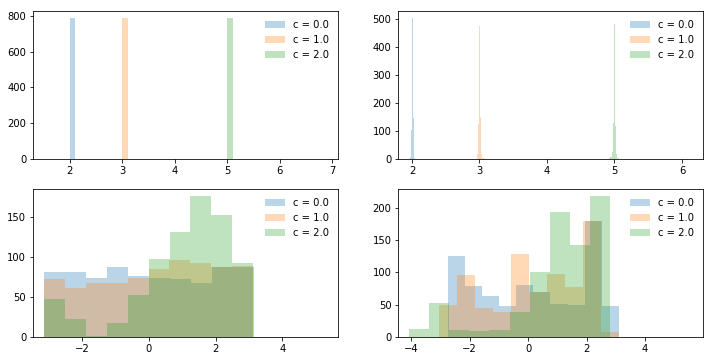

Epoch 70000 GAN loss is -5027.40771484375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0025620460510254
Fakes (c=1.0) mean is 2.9991135597229004
Fakes (c=2.0) mean is 4.993975639343262
Data (c=0.0) mean is 0.02656488612642668
Data (c=1.0) mean is 0.2712915001027107
Data (c=2.0) mean is 1.000782369262495
Fakes (c=0.0) mean is 0.1020846962928772
Fakes (c=1.0) mean is 0.13807515799999237
Fakes (c=2.0) mean is 1.0937604904174805


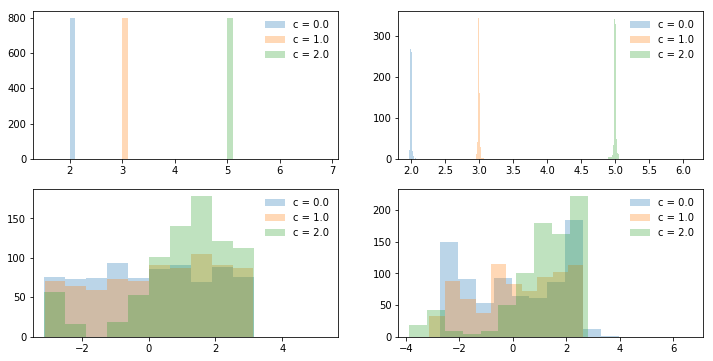

Epoch 71000 GAN loss is -5058.87548828125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.002903699874878
Fakes (c=1.0) mean is 3.0031142234802246
Fakes (c=2.0) mean is 5.001657485961914
Data (c=0.0) mean is -0.08446538636153135
Data (c=1.0) mean is 0.23328473119189327
Data (c=2.0) mean is 0.9009654209179319
Fakes (c=0.0) mean is 0.02913283370435238
Fakes (c=1.0) mean is 0.11871353536844254
Fakes (c=2.0) mean is 1.0460257530212402


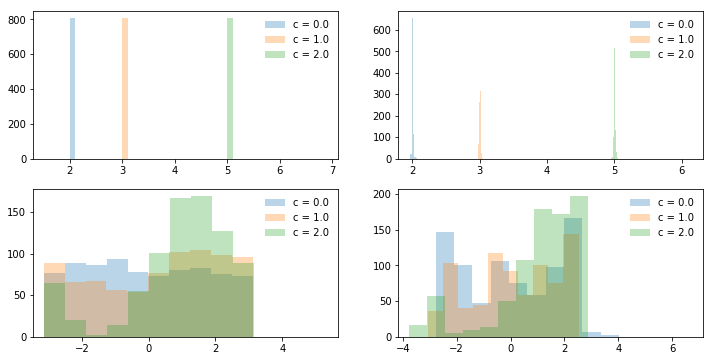

Epoch 72000 GAN loss is -5086.5322265625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.005176544189453
Fakes (c=1.0) mean is 3.0034804344177246
Fakes (c=2.0) mean is 4.9997406005859375
Data (c=0.0) mean is 0.06967669606434887
Data (c=1.0) mean is 0.21731828516725318
Data (c=2.0) mean is 1.0734980501568727
Fakes (c=0.0) mean is 0.09365646541118622
Fakes (c=1.0) mean is 0.20878568291664124
Fakes (c=2.0) mean is 1.0152103900909424


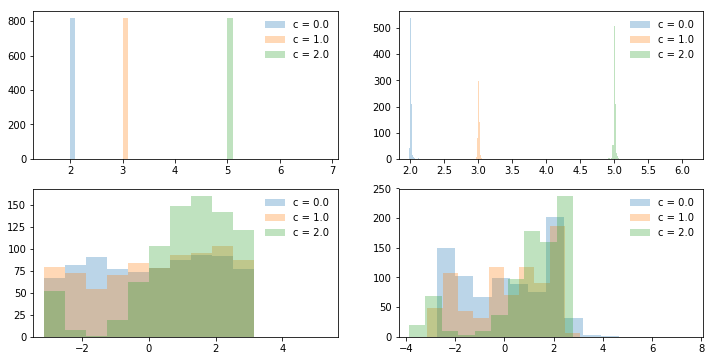

Epoch 73000 GAN loss is -5052.7470703125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.002157211303711
Fakes (c=1.0) mean is 3.0002551078796387
Fakes (c=2.0) mean is 4.995884418487549
Data (c=0.0) mean is 0.0052670685717744695
Data (c=1.0) mean is 0.2953213357327445
Data (c=2.0) mean is 1.0705777899820825
Fakes (c=0.0) mean is -0.049768149852752686
Fakes (c=1.0) mean is 0.03746836632490158
Fakes (c=2.0) mean is 1.093888521194458


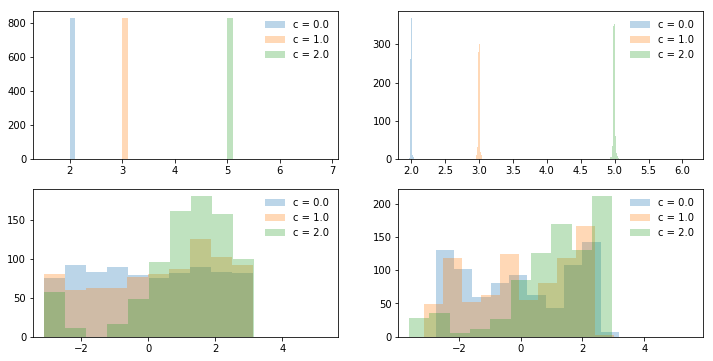

Epoch 74000 GAN loss is -5233.34521484375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0018060207366943
Fakes (c=1.0) mean is 2.99898624420166
Fakes (c=2.0) mean is 4.99293327331543
Data (c=0.0) mean is -0.005868928742447459
Data (c=1.0) mean is 0.2920354282446081
Data (c=2.0) mean is 1.0392766192837382
Fakes (c=0.0) mean is 0.06281281262636185
Fakes (c=1.0) mean is 0.13847358524799347
Fakes (c=2.0) mean is 0.9398290514945984


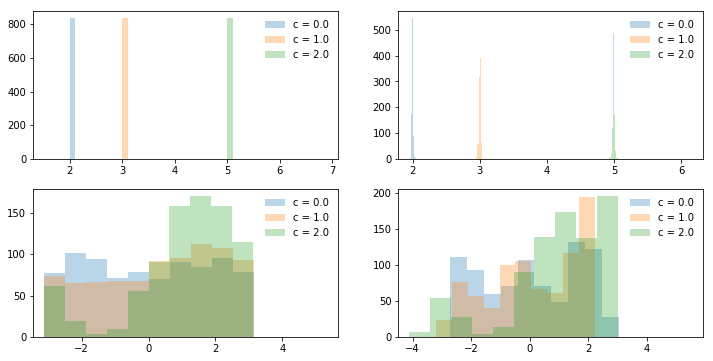

Epoch 75000 GAN loss is -5690.03564453125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0058088302612305
Fakes (c=1.0) mean is 3.0021955966949463
Fakes (c=2.0) mean is 4.99749755859375
Data (c=0.0) mean is -0.01350530487497299
Data (c=1.0) mean is 0.2917837384595609
Data (c=2.0) mean is 0.99320188624578
Fakes (c=0.0) mean is 0.11909016966819763
Fakes (c=1.0) mean is 0.19618164002895355
Fakes (c=2.0) mean is 1.1522966623306274


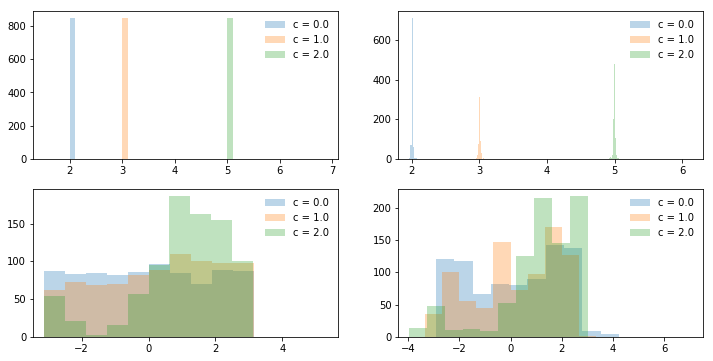

Epoch 76000 GAN loss is -5938.6572265625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0056402683258057
Fakes (c=1.0) mean is 3.0025899410247803
Fakes (c=2.0) mean is 4.9996724128723145
Data (c=0.0) mean is 0.07063131829071277
Data (c=1.0) mean is 0.2965025409118494
Data (c=2.0) mean is 1.0329830002029452
Fakes (c=0.0) mean is 0.1702575981616974
Fakes (c=1.0) mean is 0.32313817739486694
Fakes (c=2.0) mean is 1.0878082513809204


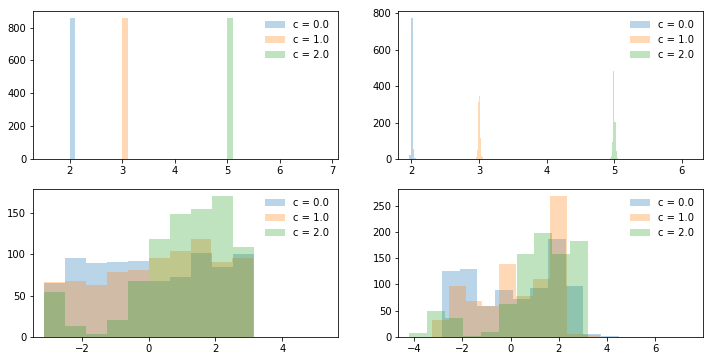

Epoch 77000 GAN loss is -6194.4013671875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0046794414520264
Fakes (c=1.0) mean is 3.000985860824585
Fakes (c=2.0) mean is 4.9956254959106445
Data (c=0.0) mean is 0.07761378563702602
Data (c=1.0) mean is 0.24886776023516108
Data (c=2.0) mean is 1.0473966899510692
Fakes (c=0.0) mean is 0.061040159314870834
Fakes (c=1.0) mean is 0.1681719720363617
Fakes (c=2.0) mean is 1.1169681549072266


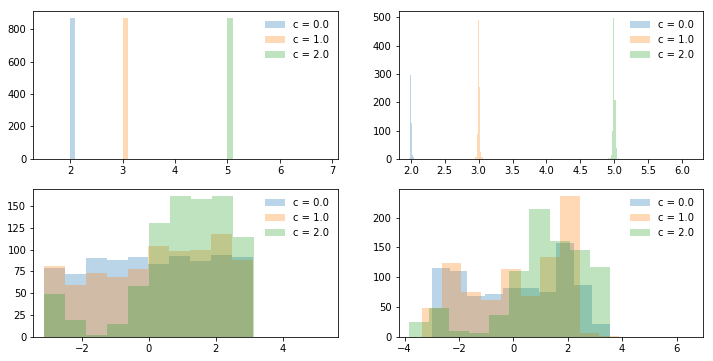

Epoch 78000 GAN loss is -6251.2490234375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.003171443939209
Fakes (c=1.0) mean is 3.0014727115631104
Fakes (c=2.0) mean is 4.999700546264648
Data (c=0.0) mean is 0.10732891112255274
Data (c=1.0) mean is 0.2030216985905472
Data (c=2.0) mean is 1.0266375349610763
Fakes (c=0.0) mean is 0.18954117596149445
Fakes (c=1.0) mean is 0.24332965910434723
Fakes (c=2.0) mean is 1.062452793121338


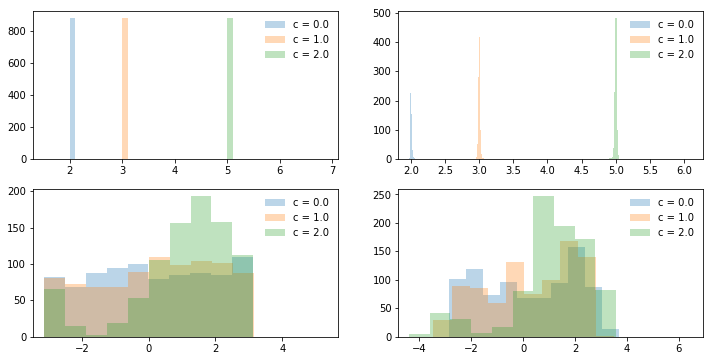

Epoch 79000 GAN loss is -6324.12451171875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.005197525024414
Fakes (c=1.0) mean is 3.002357006072998
Fakes (c=2.0) mean is 4.999001502990723
Data (c=0.0) mean is 0.014835790679350092
Data (c=1.0) mean is 0.2762119054728907
Data (c=2.0) mean is 0.9518651846047578
Fakes (c=0.0) mean is 0.05044624209403992
Fakes (c=1.0) mean is 0.17925480008125305
Fakes (c=2.0) mean is 1.019904375076294


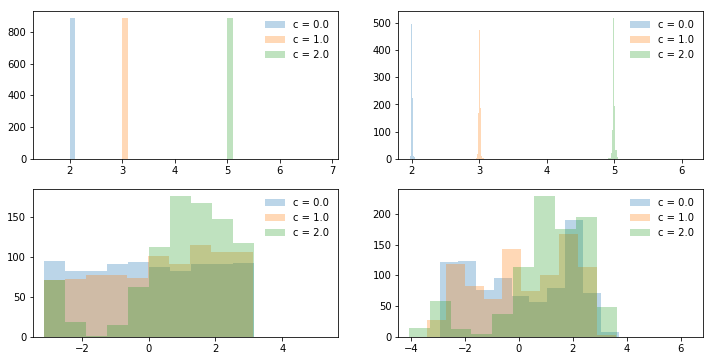

Epoch 80000 GAN loss is -6370.84814453125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0039796829223633
Fakes (c=1.0) mean is 3.0019328594207764
Fakes (c=2.0) mean is 4.997605323791504
Data (c=0.0) mean is 0.03192793733144608
Data (c=1.0) mean is 0.17507954744716725
Data (c=2.0) mean is 1.0282022025776274
Fakes (c=0.0) mean is 0.056281059980392456
Fakes (c=1.0) mean is 0.2687057554721832
Fakes (c=2.0) mean is 1.0052449703216553


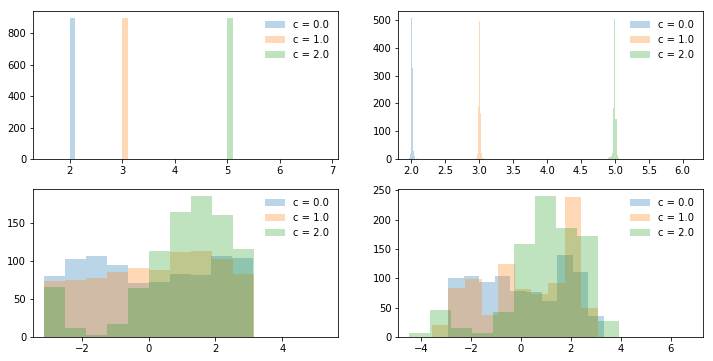

Epoch 81000 GAN loss is -6427.15966796875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.002305269241333
Fakes (c=1.0) mean is 3.0040574073791504
Fakes (c=2.0) mean is 4.991794586181641
Data (c=0.0) mean is -0.05229425958493789
Data (c=1.0) mean is 0.15934634328749356
Data (c=2.0) mean is 1.0522397623259379
Fakes (c=0.0) mean is -0.10122847557067871
Fakes (c=1.0) mean is 0.2592148184776306
Fakes (c=2.0) mean is 1.0386635065078735


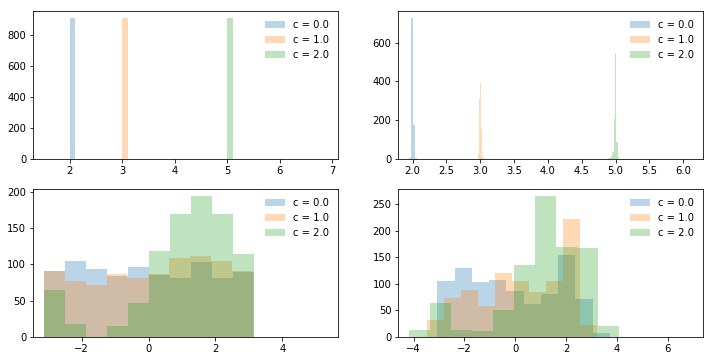

Epoch 82000 GAN loss is -6709.22802734375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0033061504364014
Fakes (c=1.0) mean is 3.004847288131714
Fakes (c=2.0) mean is 4.992912292480469
Data (c=0.0) mean is 0.1268668544397351
Data (c=1.0) mean is 0.17610221460102998
Data (c=2.0) mean is 1.0551153841595595
Fakes (c=0.0) mean is 0.00789499282836914
Fakes (c=1.0) mean is 0.22160080075263977
Fakes (c=2.0) mean is 0.9024088978767395


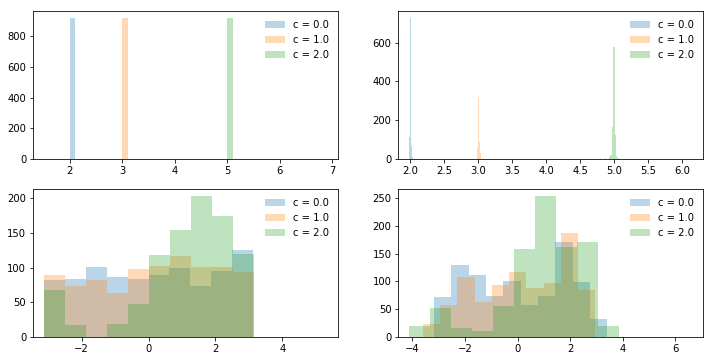

Epoch 83000 GAN loss is -7015.10546875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0033953189849854
Fakes (c=1.0) mean is 3.0040197372436523
Fakes (c=2.0) mean is 4.989126682281494
Data (c=0.0) mean is 0.041819798046871005
Data (c=1.0) mean is 0.20773475017486048
Data (c=2.0) mean is 1.0243241999239925
Fakes (c=0.0) mean is 0.0007105919648893178
Fakes (c=1.0) mean is 0.24444343149662018
Fakes (c=2.0) mean is 0.9003047943115234


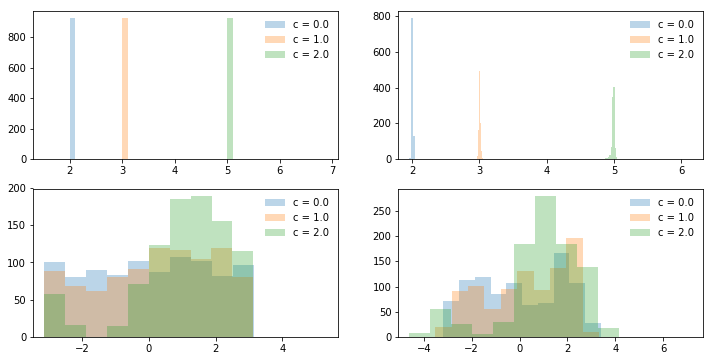

Epoch 84000 GAN loss is -7219.025390625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0020947456359863
Fakes (c=1.0) mean is 3.004514455795288
Fakes (c=2.0) mean is 4.990689277648926
Data (c=0.0) mean is 0.02108037066722887
Data (c=1.0) mean is 0.20654741957737854
Data (c=2.0) mean is 0.8897763122629201
Fakes (c=0.0) mean is 0.0226010549813509
Fakes (c=1.0) mean is 0.3198997676372528
Fakes (c=2.0) mean is 0.9060109853744507


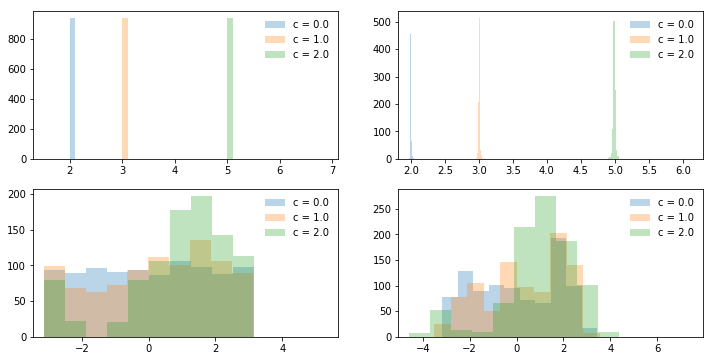

Epoch 85000 GAN loss is -7460.7734375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.001117467880249
Fakes (c=1.0) mean is 3.003403425216675
Fakes (c=2.0) mean is 4.9908037185668945
Data (c=0.0) mean is -0.02580447271673587
Data (c=1.0) mean is 0.32459449063964013
Data (c=2.0) mean is 1.0515317747779038
Fakes (c=0.0) mean is -0.03263897821307182
Fakes (c=1.0) mean is 0.4052017629146576
Fakes (c=2.0) mean is 0.8599655628204346


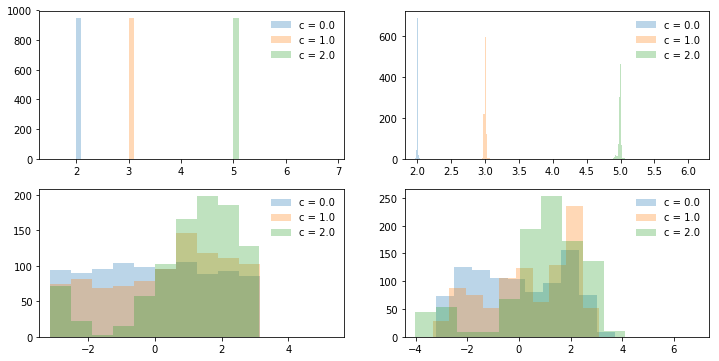

Epoch 86000 GAN loss is -7614.65478515625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0045647621154785
Fakes (c=1.0) mean is 3.0077240467071533
Fakes (c=2.0) mean is 4.9966654777526855
Data (c=0.0) mean is 0.07062121983893975
Data (c=1.0) mean is 0.16240084706101127
Data (c=2.0) mean is 0.9800651194578455
Fakes (c=0.0) mean is -0.033760327845811844
Fakes (c=1.0) mean is 0.3287433087825775
Fakes (c=2.0) mean is 0.9967795610427856


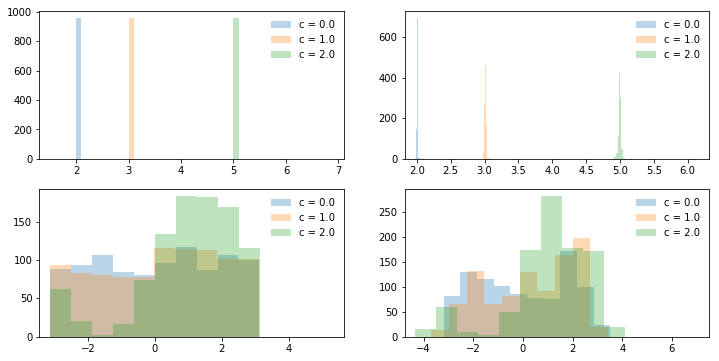

Epoch 87000 GAN loss is -7740.82080078125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0029637813568115
Fakes (c=1.0) mean is 3.0052356719970703
Fakes (c=2.0) mean is 4.993000030517578
Data (c=0.0) mean is -0.09518860260832192
Data (c=1.0) mean is 0.3247832032970729
Data (c=2.0) mean is 0.9350986283491142
Fakes (c=0.0) mean is -0.11683519929647446
Fakes (c=1.0) mean is 0.27652814984321594
Fakes (c=2.0) mean is 0.8152454495429993


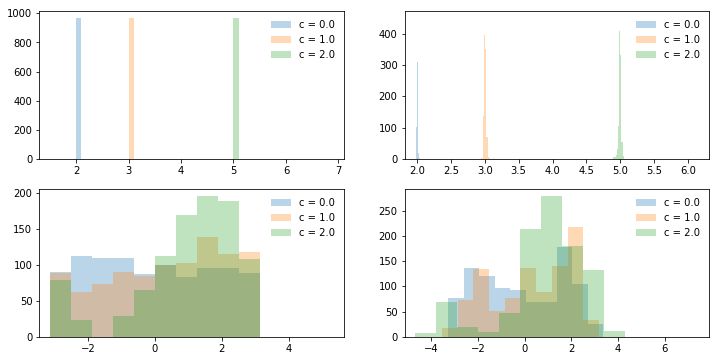

Epoch 88000 GAN loss is -7969.2548828125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0053956508636475
Fakes (c=1.0) mean is 3.007735252380371
Fakes (c=2.0) mean is 4.996274948120117
Data (c=0.0) mean is 0.011532570936073449
Data (c=1.0) mean is 0.18928653676112925
Data (c=2.0) mean is 0.9020076421836172
Fakes (c=0.0) mean is 0.06932365149259567
Fakes (c=1.0) mean is 0.3523600101470947
Fakes (c=2.0) mean is 0.751916766166687


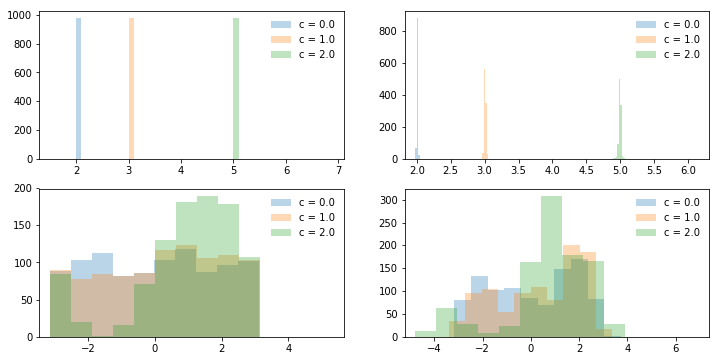

Epoch 89000 GAN loss is -8182.228515625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0044901371002197
Fakes (c=1.0) mean is 3.006404399871826
Fakes (c=2.0) mean is 4.994993686676025
Data (c=0.0) mean is -0.13596030243453977
Data (c=1.0) mean is 0.24717786527875693
Data (c=2.0) mean is 0.9554685422166643
Fakes (c=0.0) mean is 0.05690940096974373
Fakes (c=1.0) mean is 0.4685281217098236
Fakes (c=2.0) mean is 0.8373289108276367


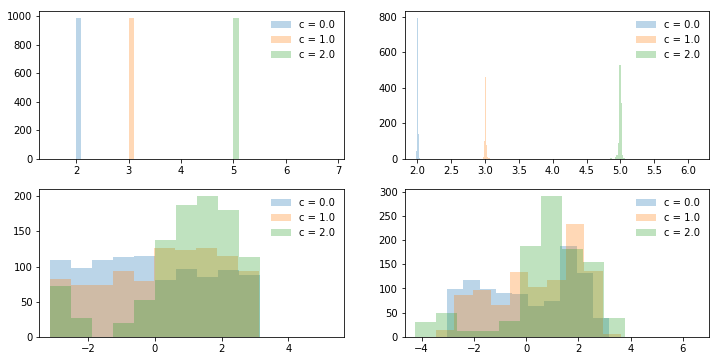

Epoch 90000 GAN loss is -8454.3291015625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.002760410308838
Fakes (c=1.0) mean is 3.0032970905303955
Fakes (c=2.0) mean is 4.99046516418457
Data (c=0.0) mean is -0.13803640174960294
Data (c=1.0) mean is 0.33750089869807404
Data (c=2.0) mean is 0.9710070975568273
Fakes (c=0.0) mean is 0.03972383216023445
Fakes (c=1.0) mean is 0.35475143790245056
Fakes (c=2.0) mean is 0.881240963935852


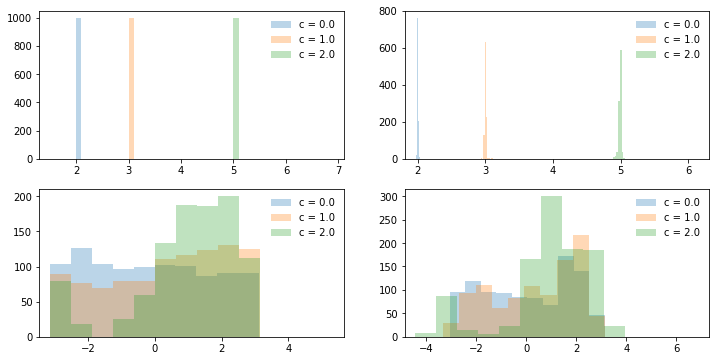

Epoch 91000 GAN loss is -8588.2490234375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0025784969329834
Fakes (c=1.0) mean is 3.0035111904144287
Fakes (c=2.0) mean is 4.989366054534912
Data (c=0.0) mean is 0.04718667675153568
Data (c=1.0) mean is 0.23920199843240597
Data (c=2.0) mean is 1.030357085357927
Fakes (c=0.0) mean is -0.03632616624236107
Fakes (c=1.0) mean is 0.4024086892604828
Fakes (c=2.0) mean is 0.9028822779655457


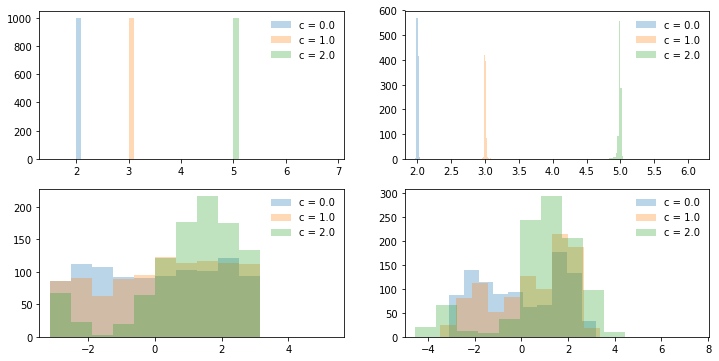

Epoch 92000 GAN loss is -8784.7509765625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0010740756988525
Fakes (c=1.0) mean is 3.001981019973755
Fakes (c=2.0) mean is 4.989442348480225
Data (c=0.0) mean is 0.1240329078527327
Data (c=1.0) mean is 0.2044037932448119
Data (c=2.0) mean is 0.954178588035345
Fakes (c=0.0) mean is -0.0032849693670868874
Fakes (c=1.0) mean is 0.34301212430000305
Fakes (c=2.0) mean is 0.8083511590957642


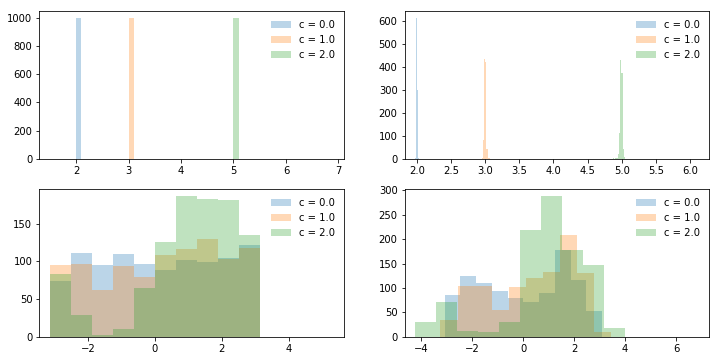

Epoch 93000 GAN loss is -8950.4228515625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0013022422790527
Fakes (c=1.0) mean is 3.001694679260254
Fakes (c=2.0) mean is 4.989258766174316
Data (c=0.0) mean is -0.026019692610323542
Data (c=1.0) mean is 0.35016991013803567
Data (c=2.0) mean is 0.9820076129147797
Fakes (c=0.0) mean is 0.11580077558755875
Fakes (c=1.0) mean is 0.37945690751075745
Fakes (c=2.0) mean is 0.8421979546546936


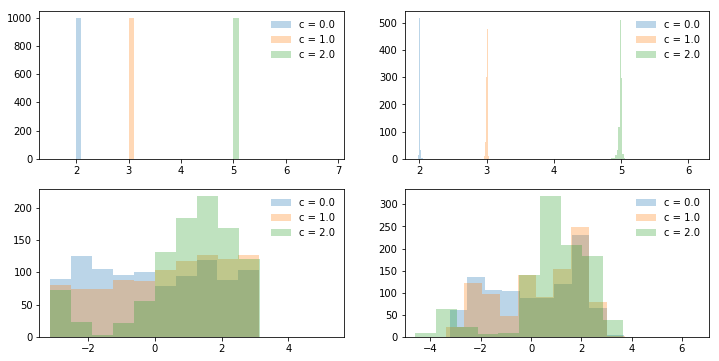

Epoch 94000 GAN loss is -9274.32421875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0035154819488525
Fakes (c=1.0) mean is 3.0028159618377686
Fakes (c=2.0) mean is 4.995292663574219
Data (c=0.0) mean is 0.004004695834391068
Data (c=1.0) mean is 0.20293455149621398
Data (c=2.0) mean is 0.9950767344847175
Fakes (c=0.0) mean is -0.015621023252606392
Fakes (c=1.0) mean is 0.413031667470932
Fakes (c=2.0) mean is 0.8889328837394714


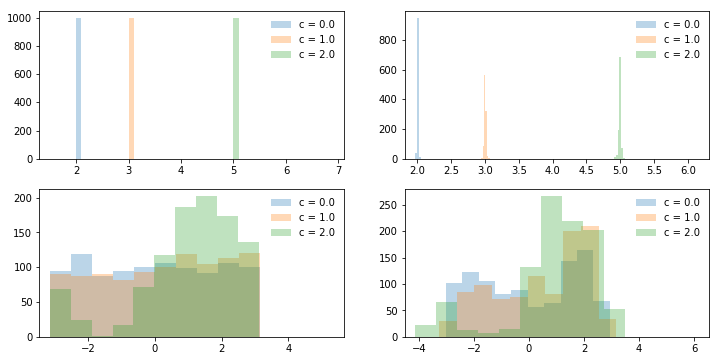

Epoch 95000 GAN loss is -9815.7666015625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0022671222686768
Fakes (c=1.0) mean is 3.0018808841705322
Fakes (c=2.0) mean is 4.993578910827637
Data (c=0.0) mean is -0.053051614870965554
Data (c=1.0) mean is 0.3044637633359924
Data (c=2.0) mean is 1.0299291673350863
Fakes (c=0.0) mean is 0.07420255988836288
Fakes (c=1.0) mean is 0.30330920219421387
Fakes (c=2.0) mean is 0.7896430492401123


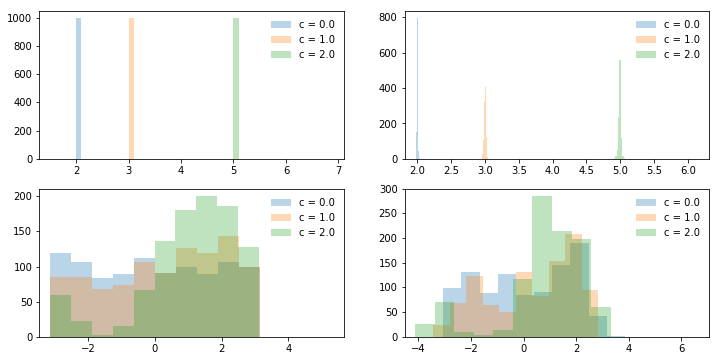

Epoch 96000 GAN loss is -10422.5009765625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.003986358642578
Fakes (c=1.0) mean is 3.0056543350219727
Fakes (c=2.0) mean is 4.999234676361084
Data (c=0.0) mean is 0.04788355187288312
Data (c=1.0) mean is 0.27023412092412535
Data (c=2.0) mean is 1.0067998812679766
Fakes (c=0.0) mean is -0.006926101632416248
Fakes (c=1.0) mean is 0.4275512099266052
Fakes (c=2.0) mean is 0.8726509809494019


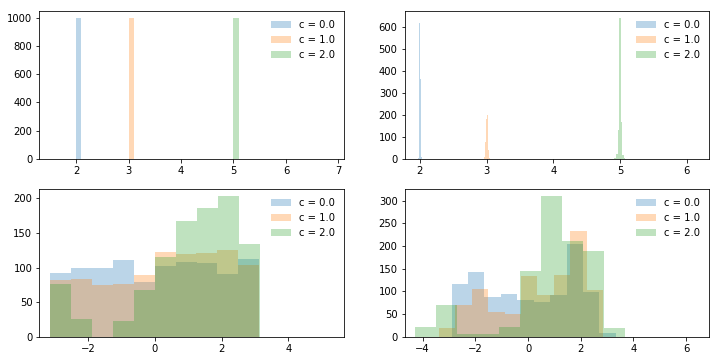

Epoch 97000 GAN loss is -11092.75390625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.002336025238037
Fakes (c=1.0) mean is 3.0032598972320557
Fakes (c=2.0) mean is 4.9976277351379395
Data (c=0.0) mean is -0.03676343163441267
Data (c=1.0) mean is 0.2535556590584351
Data (c=2.0) mean is 0.9773550047974224
Fakes (c=0.0) mean is -0.040224432945251465
Fakes (c=1.0) mean is 0.32176440954208374
Fakes (c=2.0) mean is 0.9498642683029175


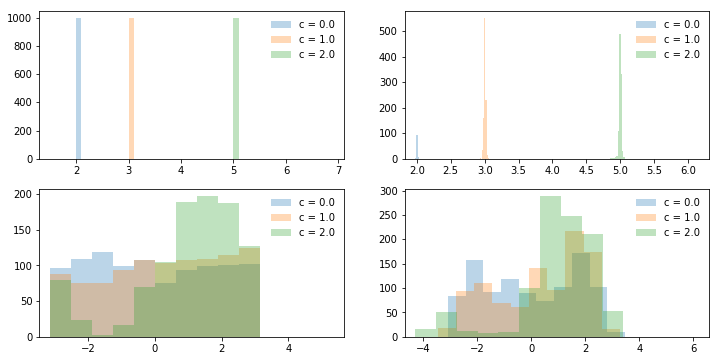

Epoch 98000 GAN loss is -11666.3095703125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.001758337020874
Fakes (c=1.0) mean is 3.0017709732055664
Fakes (c=2.0) mean is 4.994636535644531
Data (c=0.0) mean is -0.07678853783682191
Data (c=1.0) mean is 0.2923056634411418
Data (c=2.0) mean is 0.967917982680131
Fakes (c=0.0) mean is 0.006221115123480558
Fakes (c=1.0) mean is 0.3648020625114441
Fakes (c=2.0) mean is 0.8523666858673096


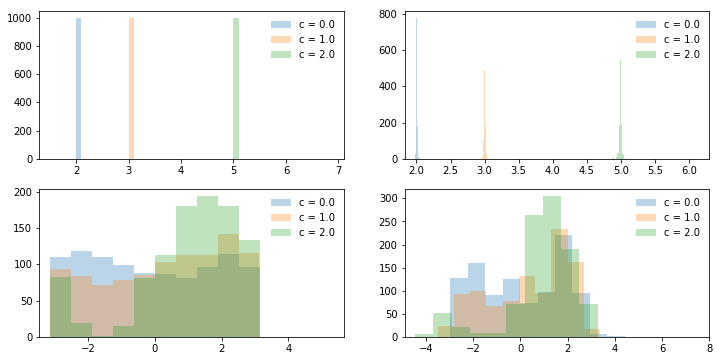

Epoch 99000 GAN loss is -11836.4853515625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0028083324432373
Fakes (c=1.0) mean is 3.001110792160034
Fakes (c=2.0) mean is 4.99377965927124
Data (c=0.0) mean is 0.019856318996456915
Data (c=1.0) mean is 0.26725734168989335
Data (c=2.0) mean is 0.96826719898589
Fakes (c=0.0) mean is -0.0030120601877570152
Fakes (c=1.0) mean is 0.33220821619033813
Fakes (c=2.0) mean is 0.8402218818664551


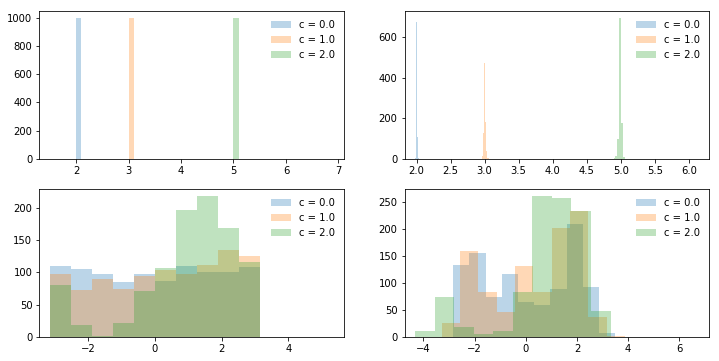

Epoch 100000 GAN loss is -12014.71875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0018532276153564
Fakes (c=1.0) mean is 3.001051187515259
Fakes (c=2.0) mean is 4.992618560791016
Data (c=0.0) mean is 0.0050974070474961945
Data (c=1.0) mean is 0.20339185415437858
Data (c=2.0) mean is 0.9592592228110844
Fakes (c=0.0) mean is 0.1377885788679123
Fakes (c=1.0) mean is 0.3150622546672821
Fakes (c=2.0) mean is 0.9265361428260803


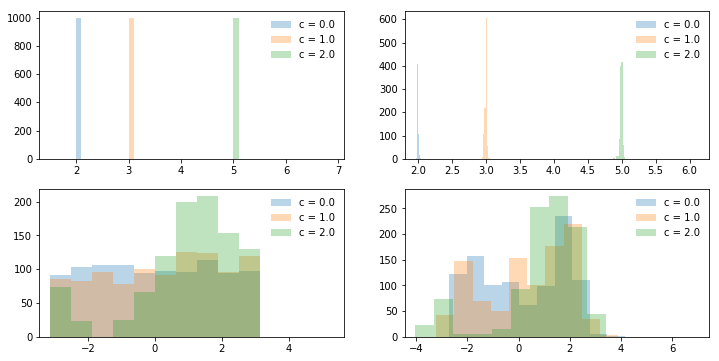

Epoch 101000 GAN loss is -12164.2294921875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0005874633789062
Fakes (c=1.0) mean is 2.998997211456299
Fakes (c=2.0) mean is 4.993546009063721
Data (c=0.0) mean is 0.011280954528682777
Data (c=1.0) mean is 0.2717506584851199
Data (c=2.0) mean is 1.0381580189309008
Fakes (c=0.0) mean is 0.05255890637636185
Fakes (c=1.0) mean is 0.3274655044078827
Fakes (c=2.0) mean is 0.9766584634780884


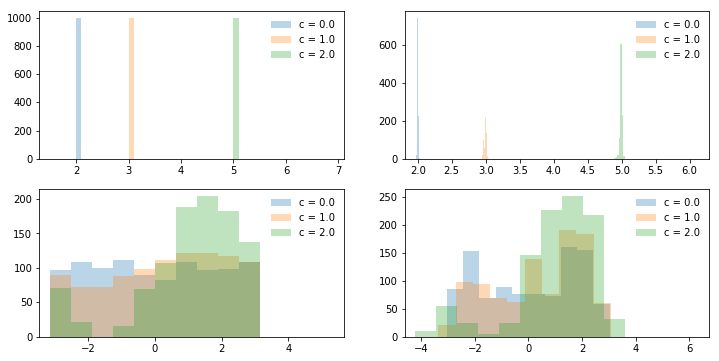

Epoch 102000 GAN loss is -11703.8203125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0026421546936035
Fakes (c=1.0) mean is 2.9994237422943115
Fakes (c=2.0) mean is 4.998840808868408
Data (c=0.0) mean is 0.12495434984537421
Data (c=1.0) mean is 0.1709250320494784
Data (c=2.0) mean is 0.9423296148334227
Fakes (c=0.0) mean is 0.054789818823337555
Fakes (c=1.0) mean is 0.30095598101615906
Fakes (c=2.0) mean is 1.033112645149231


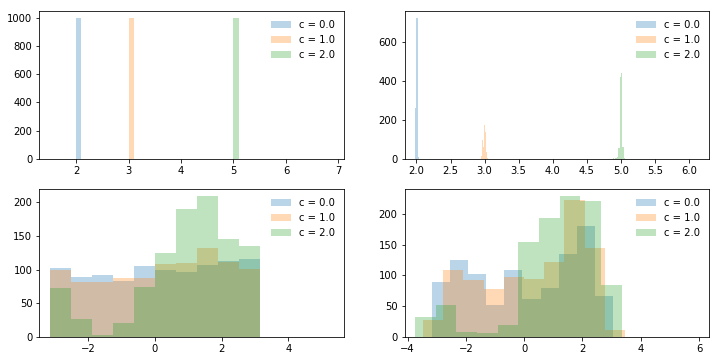

Epoch 103000 GAN loss is -11863.0146484375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0034756660461426
Fakes (c=1.0) mean is 3.001835823059082
Fakes (c=2.0) mean is 5.0032267570495605
Data (c=0.0) mean is 0.01178469800637942
Data (c=1.0) mean is 0.27269759530052873
Data (c=2.0) mean is 1.0153892897263634
Fakes (c=0.0) mean is 0.013090883381664753
Fakes (c=1.0) mean is 0.34797385334968567
Fakes (c=2.0) mean is 0.9916530847549438


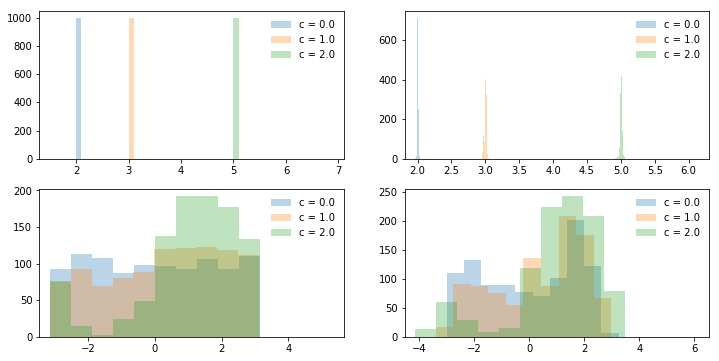

Epoch 104000 GAN loss is -12427.0009765625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0000908374786377
Fakes (c=1.0) mean is 2.9982924461364746
Fakes (c=2.0) mean is 5.000651836395264
Data (c=0.0) mean is -0.06254025446352258
Data (c=1.0) mean is 0.23107414745858046
Data (c=2.0) mean is 1.0010169329452143
Fakes (c=0.0) mean is -0.001884008408524096
Fakes (c=1.0) mean is 0.29509735107421875
Fakes (c=2.0) mean is 1.029253363609314


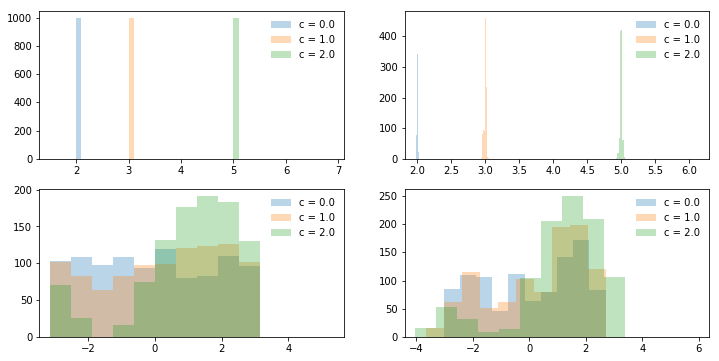

Epoch 105000 GAN loss is -12994.013671875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.003234386444092
Fakes (c=1.0) mean is 3.002775192260742
Fakes (c=2.0) mean is 5.00368070602417
Data (c=0.0) mean is 0.02701716949485656
Data (c=1.0) mean is 0.3275028634752815
Data (c=2.0) mean is 0.9692608155130326
Fakes (c=0.0) mean is 0.03556643798947334
Fakes (c=1.0) mean is 0.23016101121902466
Fakes (c=2.0) mean is 0.9868485331535339


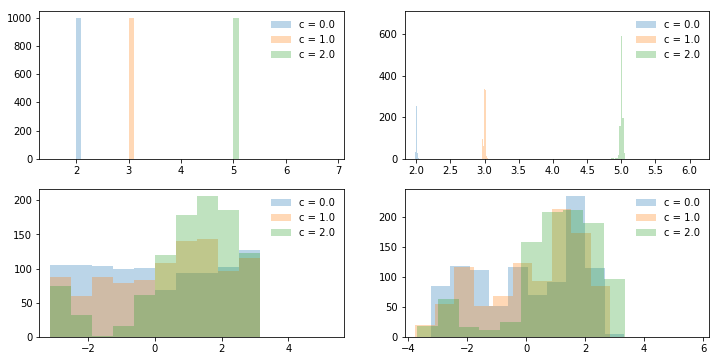

Epoch 106000 GAN loss is -13082.513671875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.9991140365600586
Fakes (c=1.0) mean is 2.997330665588379
Fakes (c=2.0) mean is 4.995129585266113
Data (c=0.0) mean is -0.023320517428813012
Data (c=1.0) mean is 0.23673515926807556
Data (c=2.0) mean is 0.9550545397032406
Fakes (c=0.0) mean is 0.10432814061641693
Fakes (c=1.0) mean is 0.1901511549949646
Fakes (c=2.0) mean is 0.9790471196174622


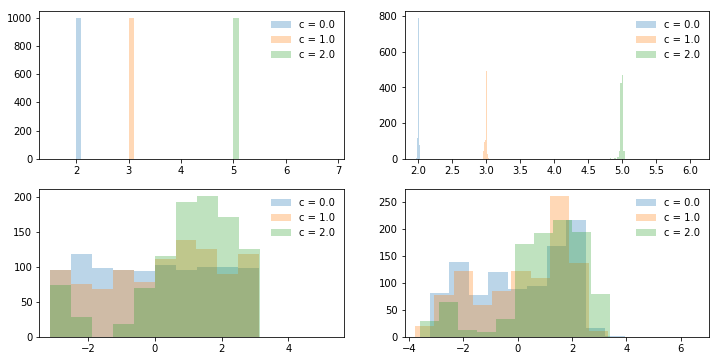

Epoch 107000 GAN loss is -13533.8330078125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0022497177124023
Fakes (c=1.0) mean is 3.0004799365997314
Fakes (c=2.0) mean is 4.996191501617432
Data (c=0.0) mean is 0.07525851613800344
Data (c=1.0) mean is 0.2238018737298071
Data (c=2.0) mean is 0.9448869608177007
Fakes (c=0.0) mean is -0.09363531321287155
Fakes (c=1.0) mean is 0.14138878881931305
Fakes (c=2.0) mean is 1.0633268356323242


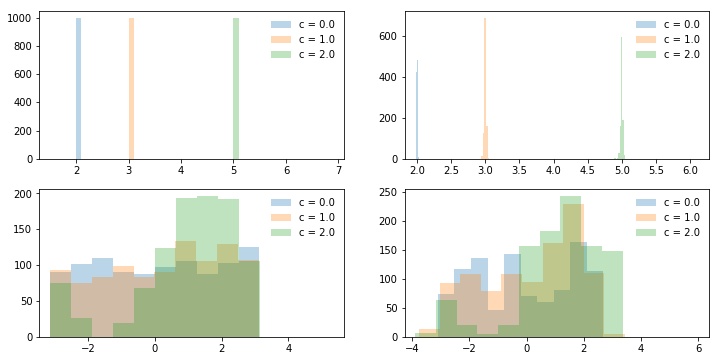

Epoch 108000 GAN loss is -14039.48828125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0004403591156006
Fakes (c=1.0) mean is 3.0001513957977295
Fakes (c=2.0) mean is 4.994541645050049
Data (c=0.0) mean is 0.01384823124441848
Data (c=1.0) mean is 0.14731961448688805
Data (c=2.0) mean is 1.101912905840728
Fakes (c=0.0) mean is 0.004549224860966206
Fakes (c=1.0) mean is 0.12188276648521423
Fakes (c=2.0) mean is 1.126407265663147


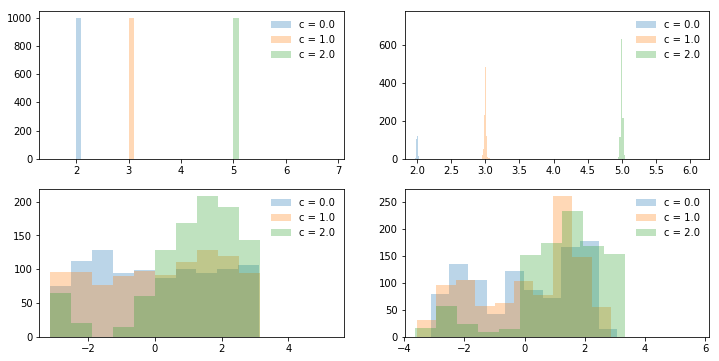

Epoch 109000 GAN loss is -14243.3037109375
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.001387596130371
Fakes (c=1.0) mean is 3.001030206680298
Fakes (c=2.0) mean is 4.998874664306641
Data (c=0.0) mean is -0.021131881864449115
Data (c=1.0) mean is 0.2698129267269971
Data (c=2.0) mean is 0.9383837397085949
Fakes (c=0.0) mean is 0.031433429569005966
Fakes (c=1.0) mean is 0.22316046059131622
Fakes (c=2.0) mean is 1.0997514724731445


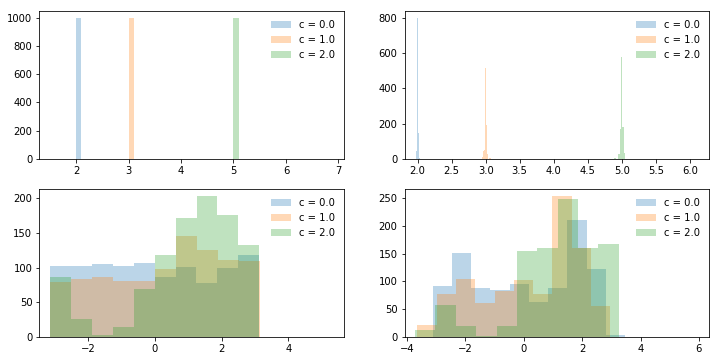

Epoch 110000 GAN loss is -14512.81640625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.000288724899292
Fakes (c=1.0) mean is 2.9999208450317383
Fakes (c=2.0) mean is 4.993686676025391
Data (c=0.0) mean is -0.055762082741722466
Data (c=1.0) mean is 0.32761256239163733
Data (c=2.0) mean is 1.0359589000159262
Fakes (c=0.0) mean is 0.032281480729579926
Fakes (c=1.0) mean is 0.10705725103616714
Fakes (c=2.0) mean is 1.0964674949645996


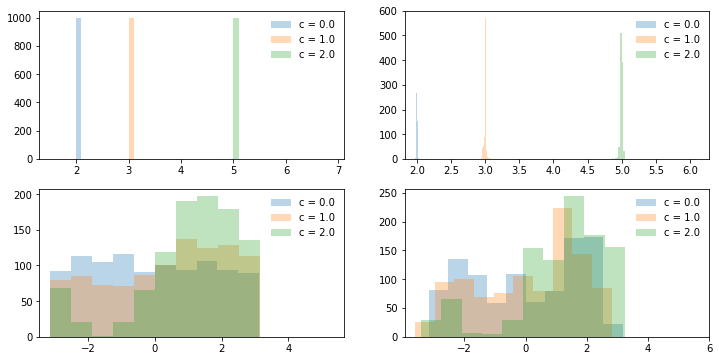

Epoch 111000 GAN loss is -14647.3544921875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0000367164611816
Fakes (c=1.0) mean is 3.0004570484161377
Fakes (c=2.0) mean is 4.995013236999512
Data (c=0.0) mean is 0.017469129717696107
Data (c=1.0) mean is 0.2673602841749429
Data (c=2.0) mean is 0.93231364449429
Fakes (c=0.0) mean is -0.061798933893442154
Fakes (c=1.0) mean is 0.06022430956363678
Fakes (c=2.0) mean is 1.1697731018066406


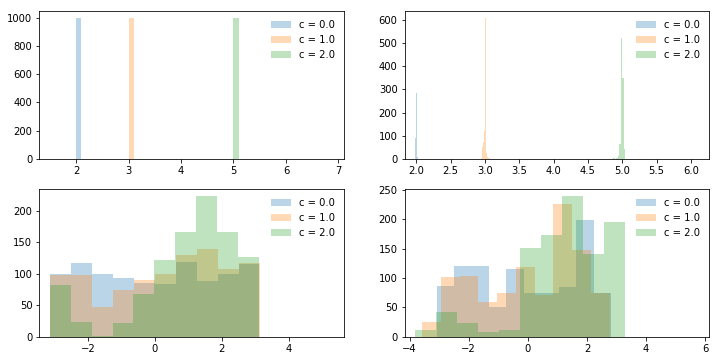

Epoch 112000 GAN loss is -15418.8291015625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0032713413238525
Fakes (c=1.0) mean is 3.0048418045043945
Fakes (c=2.0) mean is 4.999412536621094
Data (c=0.0) mean is 0.08886512689903717
Data (c=1.0) mean is 0.1945186000575107
Data (c=2.0) mean is 1.0164392839739782
Fakes (c=0.0) mean is 0.08658665418624878
Fakes (c=1.0) mean is 0.1652613878250122
Fakes (c=2.0) mean is 1.1134198904037476


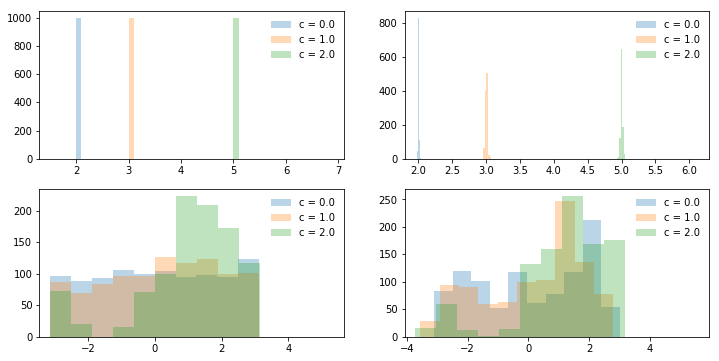

Epoch 113000 GAN loss is -15720.1337890625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0023903846740723
Fakes (c=1.0) mean is 3.0039663314819336
Fakes (c=2.0) mean is 5.0005202293396
Data (c=0.0) mean is -0.015832001241133355
Data (c=1.0) mean is 0.26039903713800017
Data (c=2.0) mean is 1.002306689787206
Fakes (c=0.0) mean is 0.06867321580648422
Fakes (c=1.0) mean is 0.09775059670209885
Fakes (c=2.0) mean is 1.022821068763733


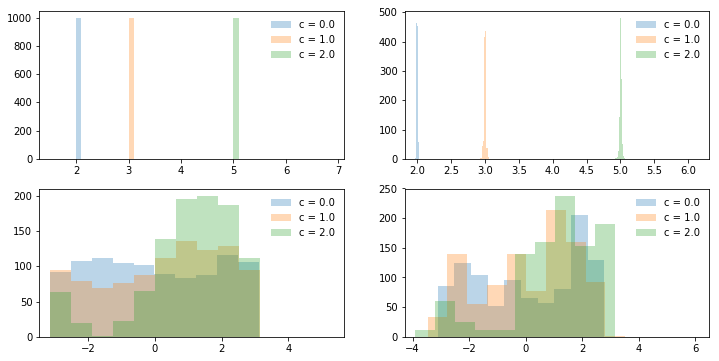

Epoch 114000 GAN loss is -16081.138671875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0016567707061768
Fakes (c=1.0) mean is 3.0002777576446533
Fakes (c=2.0) mean is 4.9938201904296875
Data (c=0.0) mean is 0.05391391627354884
Data (c=1.0) mean is 0.3360805998250362
Data (c=2.0) mean is 0.9720619247246279
Fakes (c=0.0) mean is -0.07076330482959747
Fakes (c=1.0) mean is 0.13552850484848022
Fakes (c=2.0) mean is 1.0373667478561401


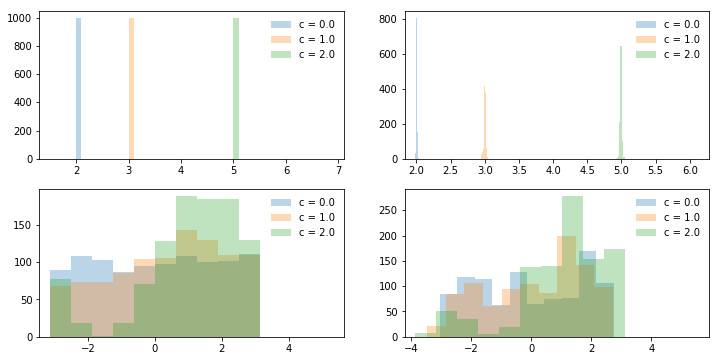

Epoch 115000 GAN loss is -16528.0390625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0017147064208984
Fakes (c=1.0) mean is 3.0006418228149414
Fakes (c=2.0) mean is 4.994930744171143
Data (c=0.0) mean is 0.013559274435104924
Data (c=1.0) mean is 0.24432944657283082
Data (c=2.0) mean is 0.9846098946863965
Fakes (c=0.0) mean is -0.012305788695812225
Fakes (c=1.0) mean is 0.033664852380752563
Fakes (c=2.0) mean is 1.0274136066436768


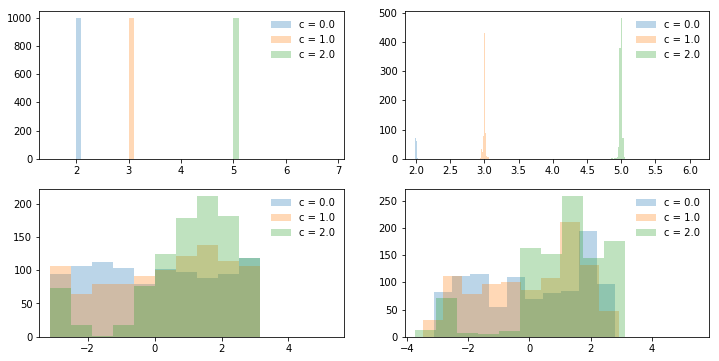

Epoch 116000 GAN loss is -17049.998046875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0023739337921143
Fakes (c=1.0) mean is 3.002143621444702
Fakes (c=2.0) mean is 4.997045040130615
Data (c=0.0) mean is 0.0645943040237793
Data (c=1.0) mean is 0.22828032285112987
Data (c=2.0) mean is 1.0208261233058888
Fakes (c=0.0) mean is -0.04902830347418785
Fakes (c=1.0) mean is 0.10468240082263947
Fakes (c=2.0) mean is 1.0867557525634766


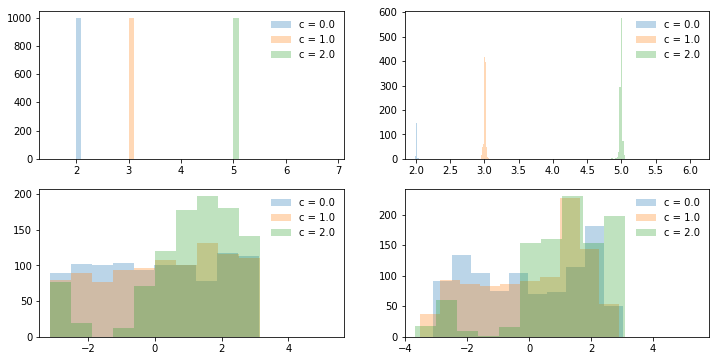

Epoch 117000 GAN loss is -17380.123046875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0017573833465576
Fakes (c=1.0) mean is 3.0018248558044434
Fakes (c=2.0) mean is 4.99555778503418
Data (c=0.0) mean is 0.009297184125252425
Data (c=1.0) mean is 0.2941115120725158
Data (c=2.0) mean is 1.0867553252216002
Fakes (c=0.0) mean is -0.028140518814325333
Fakes (c=1.0) mean is 0.22719219326972961
Fakes (c=2.0) mean is 1.10981023311615


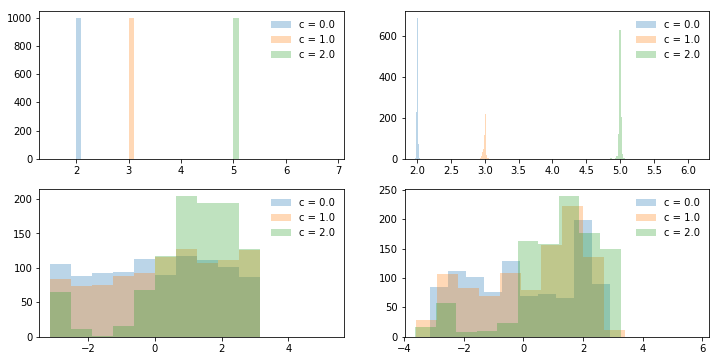

Epoch 118000 GAN loss is -17631.498046875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.004927635192871
Fakes (c=1.0) mean is 3.0045785903930664
Fakes (c=2.0) mean is 4.999251842498779
Data (c=0.0) mean is 0.07398206696641638
Data (c=1.0) mean is 0.2365697955875196
Data (c=2.0) mean is 0.8963302563556792
Fakes (c=0.0) mean is -0.03356239199638367
Fakes (c=1.0) mean is 0.1660529226064682
Fakes (c=2.0) mean is 1.0868961811065674


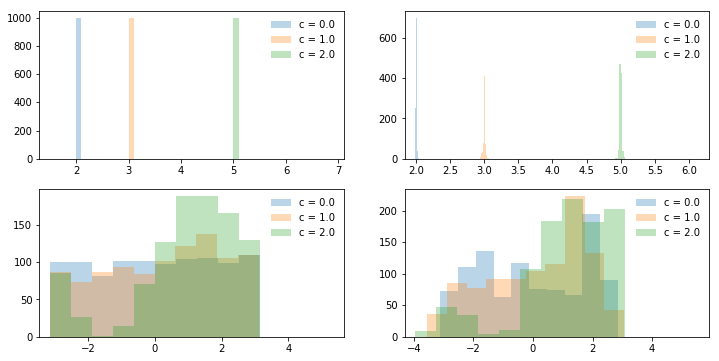

Epoch 119000 GAN loss is -18082.9921875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0022997856140137
Fakes (c=1.0) mean is 3.002004384994507
Fakes (c=2.0) mean is 4.999246597290039
Data (c=0.0) mean is -0.006460056315037573
Data (c=1.0) mean is 0.2636030221532355
Data (c=2.0) mean is 0.9504455168134043
Fakes (c=0.0) mean is -0.045489419251680374
Fakes (c=1.0) mean is 0.1547320932149887
Fakes (c=2.0) mean is 1.1552228927612305


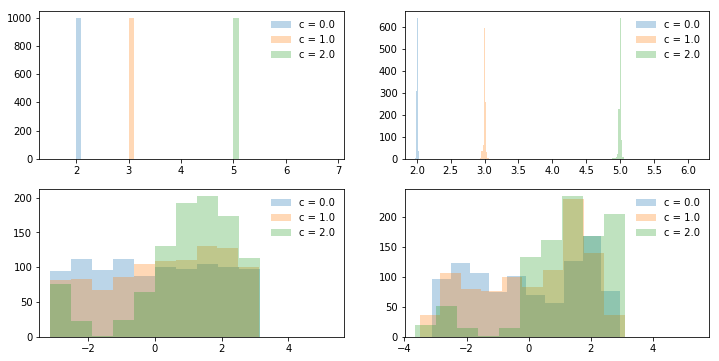

Epoch 120000 GAN loss is -18549.009765625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0038065910339355
Fakes (c=1.0) mean is 3.0046679973602295
Fakes (c=2.0) mean is 5.001595497131348
Data (c=0.0) mean is 0.03494641476499861
Data (c=1.0) mean is 0.2734299766950096
Data (c=2.0) mean is 1.048604369131519
Fakes (c=0.0) mean is 0.08790870010852814
Fakes (c=1.0) mean is 0.14871551096439362
Fakes (c=2.0) mean is 1.1311753988265991


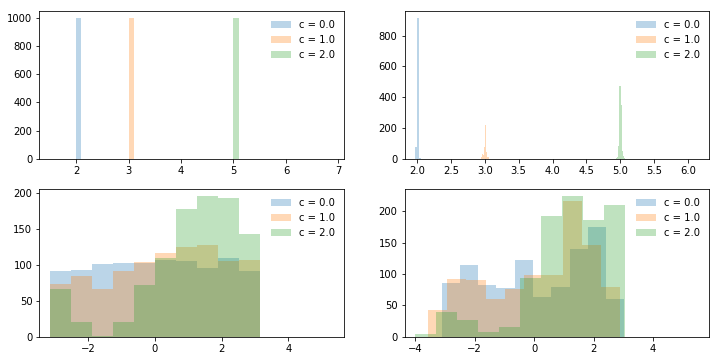

Epoch 121000 GAN loss is -18938.35546875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.003051280975342
Fakes (c=1.0) mean is 3.002110004425049
Fakes (c=2.0) mean is 4.998519420623779
Data (c=0.0) mean is -0.07153982367806479
Data (c=1.0) mean is 0.2799616691915382
Data (c=2.0) mean is 0.9713602933740564
Fakes (c=0.0) mean is 0.07015882432460785
Fakes (c=1.0) mean is 0.2511502504348755
Fakes (c=2.0) mean is 1.1309369802474976


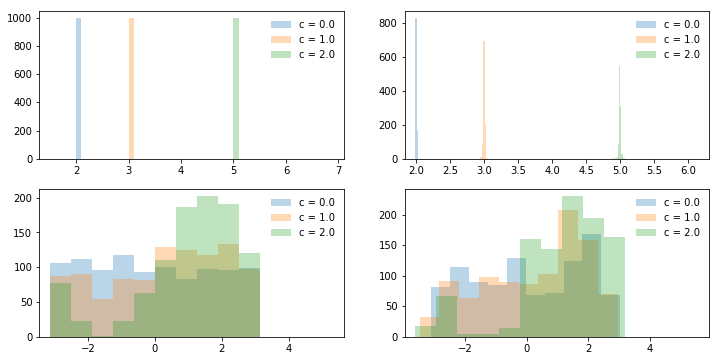

Epoch 122000 GAN loss is -19266.36328125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0026378631591797
Fakes (c=1.0) mean is 3.0030765533447266
Fakes (c=2.0) mean is 5.000247955322266
Data (c=0.0) mean is 0.1420075532881997
Data (c=1.0) mean is 0.149571830805408
Data (c=2.0) mean is 0.9893239830696815
Fakes (c=0.0) mean is -0.02621537446975708
Fakes (c=1.0) mean is 0.249986469745636
Fakes (c=2.0) mean is 1.0222493410110474


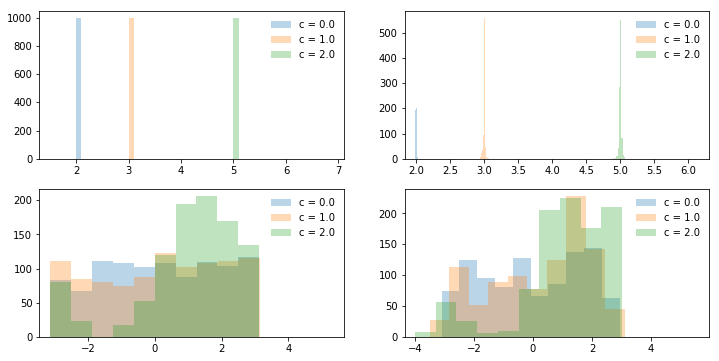

Epoch 123000 GAN loss is -19779.533203125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.003089427947998
Fakes (c=1.0) mean is 3.0034422874450684
Fakes (c=2.0) mean is 5.000154972076416
Data (c=0.0) mean is 0.05088704248582899
Data (c=1.0) mean is 0.2695193544289875
Data (c=2.0) mean is 0.9682395928325386
Fakes (c=0.0) mean is -0.04098876193165779
Fakes (c=1.0) mean is 0.21276751160621643
Fakes (c=2.0) mean is 1.0276037454605103


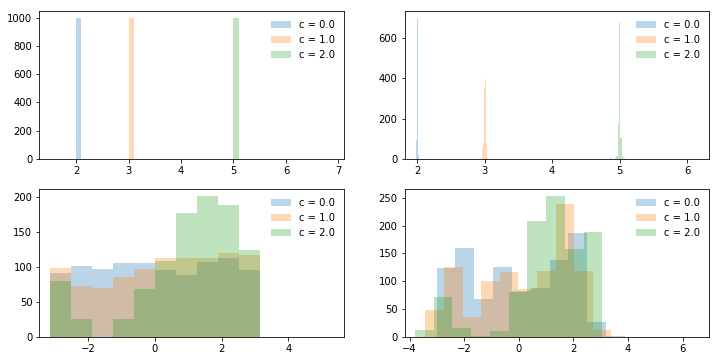

Epoch 124000 GAN loss is -20124.47265625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.9999713897705078
Fakes (c=1.0) mean is 2.9992713928222656
Fakes (c=2.0) mean is 4.994262218475342
Data (c=0.0) mean is -0.06008843576019746
Data (c=1.0) mean is 0.278327812166387
Data (c=2.0) mean is 1.0088400590664464
Fakes (c=0.0) mean is 0.05931788682937622
Fakes (c=1.0) mean is 0.29699409008026123
Fakes (c=2.0) mean is 1.159414529800415


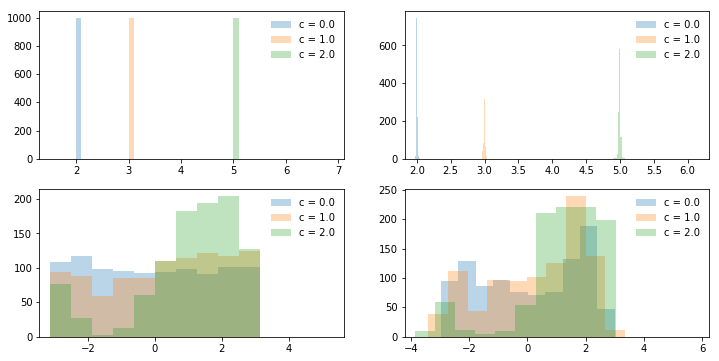

Epoch 125000 GAN loss is -20584.62890625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.002377986907959
Fakes (c=1.0) mean is 3.00148868560791
Fakes (c=2.0) mean is 4.996164321899414
Data (c=0.0) mean is 0.041918356851761755
Data (c=1.0) mean is 0.35435540611382743
Data (c=2.0) mean is 0.9703562632113071
Fakes (c=0.0) mean is 0.03306328505277634
Fakes (c=1.0) mean is 0.3352515995502472
Fakes (c=2.0) mean is 1.0288690328598022


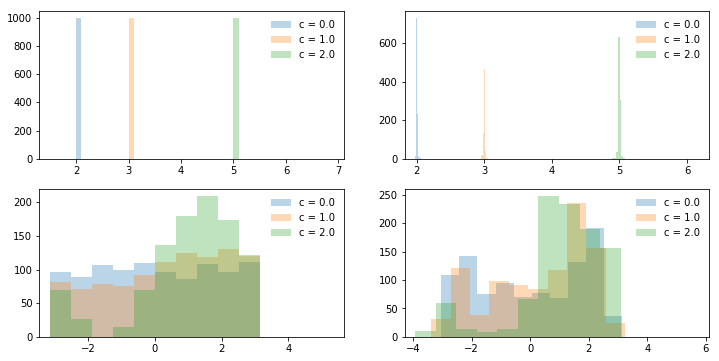

Epoch 126000 GAN loss is -20948.3671875
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0023038387298584
Fakes (c=1.0) mean is 3.0014584064483643
Fakes (c=2.0) mean is 4.9987287521362305
Data (c=0.0) mean is -0.12015961521698774
Data (c=1.0) mean is 0.28538457126604216
Data (c=2.0) mean is 1.0055546073934096
Fakes (c=0.0) mean is -0.004330925177782774
Fakes (c=1.0) mean is 0.17526030540466309
Fakes (c=2.0) mean is 1.0957741737365723


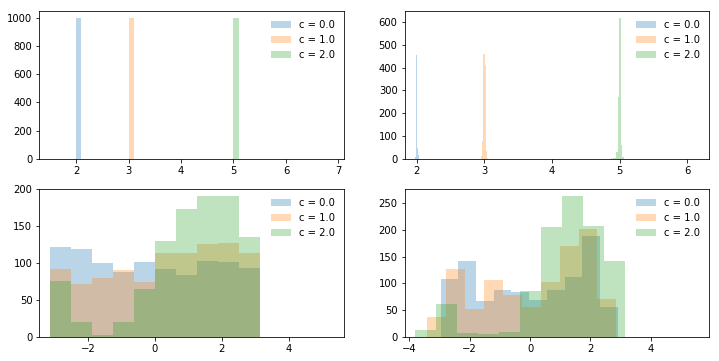

Epoch 127000 GAN loss is -21229.525390625
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0030698776245117
Fakes (c=1.0) mean is 3.002187967300415
Fakes (c=2.0) mean is 4.994804859161377
Data (c=0.0) mean is -0.03616394168259598
Data (c=1.0) mean is 0.22883087120231682
Data (c=2.0) mean is 1.08116900436111
Fakes (c=0.0) mean is 0.005838850047439337
Fakes (c=1.0) mean is 0.23609884083271027
Fakes (c=2.0) mean is 1.1665306091308594


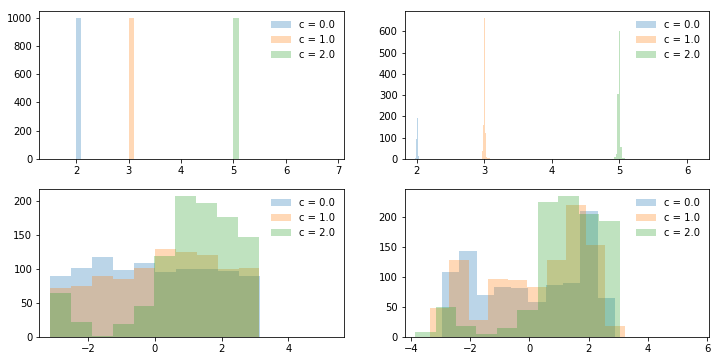

Epoch 128000 GAN loss is -21790.53125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 2.0015435218811035
Fakes (c=1.0) mean is 3.0001816749572754
Fakes (c=2.0) mean is 4.9955244064331055
Data (c=0.0) mean is -0.054134851268888
Data (c=1.0) mean is 0.2812793735277196
Data (c=2.0) mean is 0.979953431912259
Fakes (c=0.0) mean is 0.01749291829764843
Fakes (c=1.0) mean is 0.3029356896877289
Fakes (c=2.0) mean is 1.0637320280075073


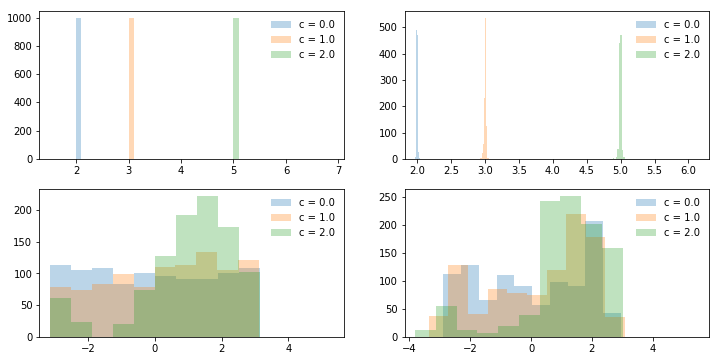

Epoch 129000 GAN loss is -22134.125
Data (c=0.0) mean is 2.0
Data (c=1.0) mean is 3.0
Data (c=2.0) mean is 5.0
Fakes (c=0.0) mean is 1.9994312524795532
Fakes (c=1.0) mean is 2.9974331855773926
Fakes (c=2.0) mean is 4.99444580078125
Data (c=0.0) mean is 0.16501417354307182
Data (c=1.0) mean is 0.30952342807714206
Data (c=2.0) mean is 0.990764724625244
Fakes (c=0.0) mean is 0.09207116812467575
Fakes (c=1.0) mean is 0.17067331075668335
Fakes (c=2.0) mean is 0.9866201877593994


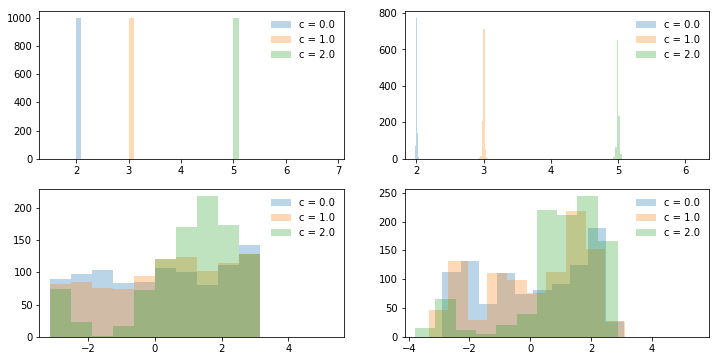

KeyboardInterrupt: 

In [12]:
#  Train GAN

#epochs                        = 10000
original_batch_size           = 100
max_batch_size                = 1000
critic_itrs_per_generator_itr = 5
num_conditions                = len(train_points_c)
epoch_print_interval          = 1000

critic, generator, GAN = make_new_critic_generator_wgan(num_observables, verbose=False)

epoch_idx = -1
while True :
    epoch_idx = epoch_idx + 1
    
    batch_size = get_batch_size(original_batch_size, max_batch_size, epoch_idx)
    data_batch , data_conditions  = get_train_data (batch_size, train_points_c, datasets)
    fakes_batch, fakes_conditions = get_train_fakes(batch_size, train_points_c, GAN_noise_size, generator)
    
    data_labels = np.array([1.  for i in range(num_conditions*batch_size)])
    fake_labels = np.array([-1. for i in range(num_conditions*batch_size)])
    
    critic_train_X_datapoints = np.concatenate([data_batch     , fakes_batch     ])
    critic_train_X_conditions = np.concatenate([data_conditions, fakes_conditions])
    critic_train_Y_labels     = np.concatenate([data_labels    , fake_labels     ])
    critic_train_X = [critic_train_X_datapoints, critic_train_X_conditions]
    
    # train discriminator
    critic.trainable = True
    for critich_update_itr in range(critic_itrs_per_generator_itr) :
        critic_loss = critic.train_on_batch(critic_train_X, -1.*critic_train_Y_labels)
    
    # train generator
    new_noise, new_conditions = get_noise (batch_size, train_points_c, GAN_noise_size)
    generator_train_X = [new_noise, new_conditions]
    critic   .trainable = False
    generator.trainable = True
    GAN_loss = GAN.train_on_batch(generator_train_X, fake_labels)
    
    if epoch_idx % epoch_print_interval != 0 : continue
    print(f"Epoch {epoch_idx} GAN loss is {GAN_loss}")
    
    data_batch , data_conditions  = get_train_data (batch_size, train_points_c, datasets)
    fakes_batch, fakes_conditions = get_train_fakes(batch_size, train_points_c, GAN_noise_size, generator)
    plot_progress (train_points_c, data_batch, data_conditions, fakes_batch, fakes_conditions)
    

In [ ]:
new_noise = np.random.normal(size=(10000,3))
new_hyperparams = np.full(fill_value=1.5, shape=(10000,))
new_generated_points = generator.predict([new_noise, new_hyperparams])[:,0]
plt.hist(new_generated_points)
plt.show()

In [ ]:
class Series : 
    def __add__ (self, other) :
        other_series = Series(other)
        items = {}
        for i, num_i in self.terms.items() :
            items[i] = num_i
        for j, num_j in other_series.terms.items() :
            items[j] = items.get(j, 0) + num_j
        return Series(items)
    def __init__ (self, other=[]) :
        if type(other) == dict :
            self.terms = {str(i):int(j) for i,j in other.items()}
        elif type(other) == list :
            self.terms = {str(i):1 for i in other}
        elif type(other) == Series :
            self.terms = {str(i):j for i,j in other.terms.items()}
        else :
            self.terms = {str(other):1}
    def __len__ (self) :
        return len(self.terms)
    def __mul__ (self, other) :
        other_series = Series(other)
        items = {}
        for i, num_i in self.terms.items() :
            for j, num_j in other_series.terms.items() :
                num_ij = num_i*num_j
                key = f"{i} * {j}"
                if j > i : key = f"{j} * {i}"
                items[key] = items.get(key, 0) + num_ij
        return Series(items)
    def __str__ (self) :
        ret = ""
        for i, num_i in self.terms.items() :
            if num_i == 0 : continue
            term_prefix = str(np.abs(num_i))+" * "
            if num_i in [1, -1]  : term_prefix = ""
            if len(ret) == 0 :
                if num_i < 0 : ret = f"-{term_prefix}{i}"
                else         : ret = f"{term_prefix}{i}"
            elif num_i < 0 : ret = ret + f" - {term_prefix}{i}"
            else           : ret = ret + f" + {term_prefix}{i}"
        return ret
    def __sub__ (self, other) :
        other_series = Series(other)
        return self + other*-1
        

In [ ]:
WI_mn = Series({"d_m * WI_n":1, "d_n * WI_m":-1, "eIJK * WJ_m * WJ_n":-1})
B_ab = Series({"d_a * B_b":1, "d_b * B_a":-1})
O_cHWB = WI_mn*B_ab*"tau_I"
for term, factor in O_cHWB.terms.items() :
    print(f"{str(factor).ljust(3)}    {term}")

In [ ]:
WI_mn_til = Series({"d_r * WI_o":1, "d_o * WI_r":-1, "eIJK * WJ_r * WJ_o":-1}) * "e_mnro"
O_cHWBtil = WI_mn_til*B_ab*"tau_I"
for term, factor in O_cHWBtil.terms.items() :
    print(f"{str(factor).ljust(3)}    {term}")